In [274]:
import gc
import logging
import math
import multiprocessing as mp
import os
import random
from itertools import zip_longest
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns
from rich import print
from tqdm import tqdm

from IPython.display import display, HTML

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", -1)
meanprops = dict(linestyle="-", linewidth=6, color="k", alpha=1, zorder=99)
whiskerprops = dict(linestyle="-", linewidth=0)

base_path = Path("~/Projects/failure-detection-benchmark/results").expanduser()

/tmp/ipykernel_769885/1226655517.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [275]:
def load_data():
    exp_names = [
        "svhn",
        "cifar10",
        "cifar100",
        "super_cifar100",
        "camelyon",
        "animals",
        "breeds",
        "svhn_openset",
        "animals_openset",
        "svhnvit",
        "cifar10vit",
        "cifar100vit",
        "super_cifar100vit",
        "camelyonvit",
        "animalsvit",
        "breedsvit",
        "svhn_opensetvit",
        "animals_opensetvit",
    ]

    df_list = []
    for exp in exp_names:
        # in_path = os.path.join("/Users/Paul/research/files/analysis/csvs/{}_paper_sweep.csv".format(exp))
        # in_path = os.path.join(
        #     "/home/tillb/Projects/failure-detection-benchmark/results/{}.csv".format(exp)
        # )
        in_path = base_path / f"{exp}.csv"
        df = pd.read_csv(in_path)
        df = df.dropna(subset=["name", "model"])
        df = df.drop_duplicates(subset=["name", "study", "model", "network", "confid"])
        df = df[
            (~df.study.str.contains("tinyimagenet_original"))
            & (~df.study.str.contains("tinyimagenet_proposed"))
        ]
        if exp == "cifar10" or exp == "cifar100" or exp == "super_cifar100":
            df = df[(df.name.str.contains("vgg13"))]
        if exp == "super_cifar100":
            df = df[df.study == "iid_study"]
            df["study"] = df.apply(
                lambda row: "cifar100_in_class_study_superclasses", axis=1
            )
        elif exp == "super_cifar100vit":
            df = df[(df.study == "iid_study")]
            df["study"] = df.apply(
                lambda row: "cifar100vit_in_class_study_superclasses", axis=1
            )
        elif exp == "svhn_openset":
            df = df[(df.study == "iid_study")]
            df["study"] = df.apply(lambda row: "svhn_openset_study", axis=1)
        elif exp == "svhn_opensetvit":
            df = df[(df.study == "iid_study")]
            df["study"] = df.apply(lambda row: "svhnvit_openset_study", axis=1)
        elif exp == "animals_openset":
            df = df[(df.study == "iid_study")]
            df["study"] = df.apply(lambda row: "animals_openset_study", axis=1)
        elif exp == "animals_opensetvit":
            df = df[(df.study == "iid_study")]
            df["study"] = df.apply(lambda row: "animalsvit_openset_study", axis=1)
        else:
            df["study"] = df.apply(lambda row: exp + "_" + row["study"], axis=1)

        df.loc[df["ece"] < 0, "ece"] = np.nan
        print(exp, len(df.groupby("name").count()))

        df_list.append(df)

    df = pd.concat(df_list)
    exp_names = [e for e in exp_names if not e.startswith("super_cifar100")]
    return df, exp_names


df, exp_names = load_data()
gc.collect()

svhn 60

cifar10 80

cifar100 90

super_cifar100 90

camelyon 120

animals 76

breeds 28

svhn_openset 20

animals_openset 20

svhnvit 34

cifar10vit 30

cifar100vit 33

super_cifar100vit 34

camelyonvit 31

animalsvit 38

breedsvit 33

svhn_opensetvit 25

animals_opensetvit 16

0

In [276]:
print(
    df[
        (df.name.str.contains("dg_bbvgg13_do1"))
        & (df.study == "cifar100_iid_study")
        & (df.confid == "dg_mcd_mcp")
    ]
)

Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, name, study, model, network, fold, confid, n_test, 
accuracy, nll, brier_score, failauc, failap_suc, failap_err, fail-NLL, mce, ece, e-aurc, 
aurc, fpr@95tpr, risk@100cov, risk@95cov, risk@90cov, risk@85cov, risk@80cov, risk@75cov, 
test_risk, test_cov, diff_risk, diff_cov, rstar, val_theta, index, old_name, lr, do, run, 
rew, bb, select_lr, select_rew]
Index: []

In [277]:
print(df.groupby("study").count())

Unnamed: 0.1  \
study                                                                      
animals_iid_study                                           508            
animals_in_class_study_wilds_animals_ood_test               508            
animals_openset_study                                       180            
animals_val_tuning                                          508            
animalsvit_iid_study                                        175            
animalsvit_in_class_study_wilds_animals_ood_test_384        169            
animalsvit_openset_study                                    128            
animalsvit_val_tuning                                       169            
breeds_iid_study                                            196            
breeds_in_class_study_breeds_ood_test                       196            
breeds_val_tuning                                           196            
breedsvit_iid_study                                         166            
breedsvit_in_class_study_breeds_ood_test_384                166            
breedsvit_val_tuning                                        162            
camelyon_iid_study                                          840            
camelyon_in_class_study_wilds_camelyon_ood_test             840            
camelyon_val_tuning                                         840            
camelyonvit_iid_study                                       158            
camelyonvit_in_class_study_wilds_camelyon_ood_test_384      158            
camelyonvit_val_tuning                                      158            
cifar100_iid_study                                          630            
cifar100_in_class_study_superclasses                        630            
cifar100_new_class_study_cifar10_original_mode              630            
cifar100_new_class_study_cifar10_proposed_mode              630            
cifar100_new_class_study_svhn_original_mode                 630            
cifar100_new_class_study_svhn_proposed_mode                 630            
cifar100_new_class_study_tinyimagenet_resize_original_mode  630            
cifar100_new_class_study_tinyimagenet_resize_proposed_mode  630            
cifar100_noise_study_1                                      630            
cifar100_noise_study_2                                      630            
cifar100_noise_study_3                                      630            
cifar100_noise_study_4                                      630            
cifar100_noise_study_5                                      630            
cifar100_val_tuning                                         630            
cifar100vit_iid_study                                       137            
cifar100vit_in_class_study_superclasses                     174            
cifar100vit_new_class_study_cifar10_384_original_mode       137            
cifar100vit_new_class_study_cifar10_384_proposed_mode       137            
cifar100vit_new_class_study_svhn_384_original_mode          137            
cifar100vit_new_class_study_svhn_384_proposed_mode          137            
cifar100vit_new_class_study_tinyimagenet_384_original_mode  137            
cifar100vit_new_class_study_tinyimagenet_384_proposed_mode  137            
cifar100vit_noise_study_1                                   126            
cifar100vit_noise_study_2                                   126            
cifar100vit_noise_study_3                                   126            
cifar100vit_noise_study_4                                   126            
cifar100vit_noise_study_5                                   126            
cifar100vit_val_tuning                                      133            
cifar10_iid_study                                           560            
cifar10_new_class_study_cifar100_original_mode              560            
cifar10_new_class_study_cifar100_proposed_mode              560            
cifar10_new_class_study_svhn_ori

In [278]:
def parse_dataframe(df: pd.DataFrame):
    df["backbone"] = df.apply(
        lambda row: row["name"].split("bb")[1].split("_")[0], axis=1
    )
    df["dropout"] = df.apply(
        lambda row: row["name"].split("do")[1].split("_")[0], axis=1
    )
    df["model"] = df.apply(
        lambda row: row["name"].split("_")[0]
        if row["backbone"] != "vit"
        else row["model"],
        axis=1,
    )
    df["model"] = df.apply(
        lambda row: "vit_" + row["model"] if row["backbone"] == "vit" else row["model"],
        axis=1,
    )
    df["run"] = df.apply(lambda row: row["name"].split("run")[1].split("_")[0], axis=1)
    df["rew"] = df.apply(lambda row: row["name"].split("_rew")[1].split("_")[0], axis=1)
    df["confid"] = df.apply(
        lambda row: row["model"]
        + "_"
        + row["confid"]
        + "_"
        + row["dropout"]
        + "_"
        + row["rew"],
        axis=1,
    )
    df = df.drop("model", axis=1)
    df = df.drop("dropout", axis=1)

    df = df.drop("backbone", axis=1)
    print(len(df))
    # print(df[df.study.str.contains("cifar100vit") & df.backbone.str.contains("vit")])
    return df


df = parse_dataframe(df)
gc.collect()

31646

0

In [279]:
# MODEL SELECTION
def select_models(df):
    def select_func(row, selection_df, selection_column):
        if "openset" in row["study"]:
            return 1
        name_splitter = -1 if selection_column == "rew" else -2
        row_exp = row["study"].split("_")[0] + "_"
        row_confid = "_".join(row["confid"].split("_")[:name_splitter])
        selection_df = selection_df[
            (selection_df.study.str.contains(row_exp))
            & (selection_df.confid == row_confid)
        ]
        try:
            if row[selection_column] == selection_df[selection_column].tolist()[0]:
                return 1
            else:
                return 0
        except IndexError as e:
            print(row_exp, row_confid, len(selection_df))
            raise e

    ms_metric = "aurc"  # Careful, when changing consider changing idxmin -> idxmax

    # REWARD
    non_agg_columns = ["study", "confid", "rew"]
    ms_filter_metrics_df = df[["study", "confid", "run", "rew", ms_metric]]
    df_ms = ms_filter_metrics_df.groupby(by=non_agg_columns).mean().reset_index()
    #     print(len(df_ms), len(ms_filter_metrics_df))
    df_ms = df_ms[df_ms.study.str.contains("val_tuning")]
    df_ms["confid"] = df_ms.apply(
        lambda row: "_".join(row["confid"].split("_")[:-1]), axis=1
    )
    df_ms = df_ms.loc[
        df_ms.groupby(["study", "confid"])[ms_metric].idxmin().reset_index()[ms_metric]
    ]
    #     print(len(df), len(df_ms))
    df["select_rew"] = df.apply(lambda row: select_func(row, df_ms, "rew"), axis=1)
    selected_df = df[df.select_rew == 1]

    # DROPOUT
    non_agg_columns = ["study", "confid", "dropout"]
    selected_df["dropout"] = selected_df.apply(
        lambda row: row["name"].split("do")[1].split("_")[0], axis=1
    )
    do_filter_metrics_df = selected_df[["study", "confid", "run", "dropout", ms_metric]]
    df_do = do_filter_metrics_df.groupby(by=non_agg_columns).mean().reset_index()
    #     print(len(df_do), len(do_filter_metrics_df))
    df_do = df_do[df_do.study.str.contains("val_tuning")]
    df_do["confid"] = df_do.apply(
        lambda row: "_".join(row["confid"].split("_")[:-2]), axis=1
    )
    df_do = df_do.loc[
        df_do.groupby(["study", "confid"])[ms_metric].idxmin().reset_index()[ms_metric]
    ]
    #     print(len(df), len(selected_df), len(df_do))
    selected_df["select_do"] = selected_df.apply(
        lambda row: select_func(row, df_do, "dropout"), axis=1
    )
    all_selected_df = selected_df[selected_df.select_do == 1]
    return all_selected_df


all_selected_df = select_models(df)
del df
gc.collect()
# print(all_selected_df[all_selected_df.study == "cifar100vit_in_class_study_superclasses"])

/tmp/ipykernel_769885/1336453556.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["dropout"] = selected_df.apply(
/tmp/ipykernel_769885/1336453556.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["select_do"] = selected_df.apply(


361

In [280]:
pd.set_option("display.max_rows", 3000)
pd.set_option("display.max_columns", 200)
# print(len(df), len(selected_df), len(all_selected_df), type)
all_selected_df[
    (
        all_selected_df.study.str.contains("iid_study")
        | all_selected_df.study.str.contains("val_tuning")
    )
    & (all_selected_df.run == "1")
    # & (all_selected_df.dropout == "0")
    & (all_selected_df.study.str.startswith("breedsvit"))
][["study", "confid", "rew", "dropout", "aurc"]].sort_values("dropout")

study                          confid  rew dropout  \
350  breedsvit_iid_study   vit_vit_det_pe_0_0              0    0        
349  breedsvit_iid_study   vit_vit_det_mcp_0_0             0    0        
348  breedsvit_val_tuning  vit_vit_det_pe_0_0              0    0        
347  breedsvit_val_tuning  vit_vit_det_mcp_0_0             0    0        
115  breedsvit_iid_study   vit_vit_maha_0_0                0    0        
89   breedsvit_val_tuning  vit_vit_maha_mcd_1_0            0    1        
232  breedsvit_iid_study   vit_dg_dg_waic_1_4.5            4.5  1        
233  breedsvit_iid_study   vit_dg_mcd_mcp_1_4.5            4.5  1        
234  breedsvit_iid_study   vit_dg_mcd_pe_1_4.5             4.5  1        
235  breedsvit_iid_study   vit_dg_mcd_ee_1_4.5             4.5  1        
236  breedsvit_iid_study   vit_dg_mcd_mi_1_4.5             4.5  1        
237  breedsvit_iid_study   vit_dg_mcd_sv_1_4.5             4.5  1        
238  breedsvit_iid_study   vit_dg_mcd_waic_1_4.5           4.5  1        
337  breedsvit_val_tuning  vit_confidnet_det_mcp_1_2.2     2.2  1        
338  breedsvit_val_tuning  vit_confidnet_det_pe_1_2.2      2.2  1        
339  breedsvit_val_tuning  vit_confidnet_tcp_1_2.2         2.2  1        
341  breedsvit_iid_study   vit_confidnet_det_mcp_1_2.2     2.2  1        
231  breedsvit_iid_study   vit_dg_dg_mcd_1_4.5             4.5  1        
342  breedsvit_iid_study   vit_confidnet_det_pe_1_2.2      2.2  1        
343  breedsvit_iid_study   vit_confidnet_tcp_1_2.2         2.2  1        
344  breedsvit_iid_study   vit_confidnet_tcp_waic_1_2.2    2.2  1        
457  breedsvit_val_tuning  vit_devries_det_mcp_1_2.2       2.2  1        
458  breedsvit_val_tuning  vit_devries_det_pe_1_2.2        2.2  1        
459  breedsvit_val_tuning  vit_devries_devries_1_2.2       2.2  1        
460  breedsvit_val_tuning  vit_devries_devries_waic_1_2.2  2.2  1        
461  breedsvit_iid_study   vit_devries_det_mcp_1_2.2       2.2  1        
462  breedsvit_iid_study   vit_devries_det_pe_1_2.2        2.2  1        
340  breedsvit_val_tuning  vit_confidnet_tcp_waic_1_2.2    2.2  1        
230  breedsvit_iid_study   vit_dg_dg_1_4.5                 4.5  1        
229  breedsvit_iid_study   vit_dg_det_pe_1_4.5             4.5  1        
228  breedsvit_iid_study   vit_dg_det_mcp_1_4.5            4.5  1        
90   breedsvit_val_tuning  vit_vit_maha_waic_1_0           0    1        
91   breedsvit_val_tuning  vit_vit_mcd_mcp_1_0             0    1        
92   breedsvit_val_tuning  vit_vit_mcd_pe_1_0              0    1        
93   breedsvit_val_tuning  vit_vit_mcd_ee_1_0              0    1        
94   breedsvit_val_tuning  vit_vit_mcd_mi_1_0              0    1        
95   breedsvit_val_tuning  vit_vit_mcd_sv_1_0              0    1        
96   breedsvit_val_tuning  vit_vit_mcd_waic_1_0            0    1        
100  breedsvit_iid_study   vit_vit_maha_mcd_1_0            0    1        
101  breedsvit_iid_study   vit_vit_maha_waic_1_0           0    1        
102  breedsvit_iid_study   vit_vit_mcd_mcp_1_0             0    1        
103  breedsvit_iid_study   vit_vit_mcd_pe_1_0              0    1        
104  breedsvit_iid_study   vit_vit_mcd_ee_1_0              0    1        
463  breedsvit_iid_study   vit_devries_devries_1_2.2       2.2  1        
105  breedsvit_iid_study   vit_vit_mcd_mi_1_0              0    1        
107  breedsvit_iid_study   vit_vit_mcd_waic_1_0            0    1        
217  breedsvit_val_tuning  vit_dg_det_mcp_1_4.5            4.5  1        
218  breedsvit_val_tuning  vit_dg_det_pe_1_4.5             4.5  1        
219  breedsvit_val_tuning  vit_dg_dg_1_4.5                 4.5  1        
220  breedsvit_val_tuning  vit_dg_dg_mcd_1_4.5             4.5  1        
221  breedsvit_val_tuning  vit_dg_dg_waic_1_4.5            4.5  1        
222  breedsvit_val_tuning  vit_dg_mcd_mcp_1_4.5            4.5  1        
223  breedsvit_val_tuning  vit_dg_mcd_pe_1_4.5             4.5  1        
224  breedsvit_val_tunin

In [281]:
def clean_df(all_selected_df):
    def rename_confids(in_confid):
        confid = in_confid.replace("confidnet_", "")
        confid = confid.replace("_dg", "_res")
        # confid = confid.replace("dg_", "deepgamblers_")
        confid = confid.replace("_det", "")
        confid = confid.replace("det_", "")
        #     confid = confid.replace("_devries", "")
        confid = confid.replace("tcp", "confidnet")
        confid = confid.upper()
        confid = confid.replace("DEVRIES_DEVRIES", "DEVRIES")
        confid = confid.replace("VIT_VIT", "VIT")
        confid = confid.replace("DEVRIES", "Devries et al.")
        confid = confid.replace("CONFIDNET", "ConfidNet")
        confid = confid.replace("RES", "Res")
        confid = confid.replace("_", "-")
        confid = confid.replace("MCP", "MSR")
        confid = confid.replace("VIT-Res", "VIT-DG-Res")
        confid = confid.replace("VIT-DG-Res-", "VIT-DG-")
        return confid

    # FINAL CLEANING AND ASSIGNING OF DF
    clean_df = all_selected_df.drop("dropout", axis=1)
    # print(clean_df.confid.unique())

    # clean_df = clean_df.drop("rew", axis=1)
    clean_df = clean_df[~clean_df.confid.str.contains("waic")]
    clean_df["confid"] = clean_df.apply(
        lambda row: "_".join(row["confid"].split("_")[:-2]), axis=1
    )
    clean_df = clean_df[~clean_df.confid.str.contains("devries_mcd")]
    clean_df = clean_df[~clean_df.confid.str.contains("devries_det")]
    clean_df = clean_df[~clean_df.confid.str.contains("_sv")]
    clean_df = clean_df[~clean_df.confid.str.contains("_mi")]
    clean_df["confid"][clean_df["network"] == "vit"] = clean_df["confid"][
        clean_df["network"] == "vit"
    ].apply(lambda row: "vit_" + row)
    #     print(clean_df.confid.unique())
    clean_df["confid"] = clean_df.apply(
        lambda row: rename_confids(row["confid"]), axis=1
    )
    clean_df["study"] = clean_df.study.str.replace(
        "tinyimagenet_384", "tinyimagenet_resize"
    )
    clean_df["study"] = clean_df.study.str.replace("vit", "").str.replace("_384", "")
    df = clean_df
    #     print(df.confid.unique())
    #     print(df.study.unique())
    return df


df = clean_df(all_selected_df)
del all_selected_df
print(df[df.study.str.startswith("cifar100") & df.confid.str.contains("VIT-Devries")])
gc.collect()

/tmp/ipykernel_769885/4194919151.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["confid"][clean_df["network"] == "vit"] = clean_df["confid"][


Unnamed: 0.1  Unnamed: 0                                 name  \
868   1253          2           devries_lr0.01_do1_rew3_bbvit_run4    
872   1264          2           devries_lr0.01_do1_rew3_bbvit_run4    
876   1275          2           devries_lr0.01_do1_rew3_bbvit_run4    
880   1286          2           devries_lr0.01_do1_rew3_bbvit_run4    
884   1297          2           devries_lr0.01_do1_rew3_bbvit_run4    
888   1308          2           devries_lr0.01_do1_rew3_bbvit_run4    
892   1319          2           devries_lr0.01_do1_rew3_bbvit_run4    
896   1330          2           devries_lr0.01_do1_rew3_bbvit_run4    
900   1341          2           devries_lr0.01_do1_rew3_bbvit_run4    
904   1352          2           devries_lr0.01_do1_rew3_bbvit_run4    
908   1363          2           devries_lr0.01_do1_rew3_bbvit_run4    
912   1374          2           devries_lr0.01_do1_rew3_bbvit_run4    
916   1385          2           devries_lr0.01_do1_rew3_bbvit_run4    
1050  1708          2           devries_lr0.01_do1_rew3_bbvit_run1    
1054  1719          2           devries_lr0.01_do1_rew3_bbvit_run1    
1058  1730          2           devries_lr0.01_do1_rew3_bbvit_run1    
1062  1741          2           devries_lr0.01_do1_rew3_bbvit_run1    
1066  1752          2           devries_lr0.01_do1_rew3_bbvit_run1    
1070  1763          2           devries_lr0.01_do1_rew3_bbvit_run1    
1074  1774          2           devries_lr0.01_do1_rew3_bbvit_run1    
1078  1785          2           devries_lr0.01_do1_rew3_bbvit_run1    
1082  1796          2           devries_lr0.01_do1_rew3_bbvit_run1    
1086  1807          2           devries_lr0.01_do1_rew3_bbvit_run1    
1090  1818          2           devries_lr0.01_do1_rew3_bbvit_run1    
1094  1829          2           devries_lr0.01_do1_rew3_bbvit_run1    
1098  1840          2           devries_lr0.01_do1_rew3_bbvit_run1    
1102  1851          2           devries_lr0.01_do1_rew3_bbvit_run2    
1106  1862          2           devries_lr0.01_do1_rew3_bbvit_run2    
1110  1873          2           devries_lr0.01_do1_rew3_bbvit_run2    
1114  1884          2           devries_lr0.01_do1_rew3_bbvit_run2    
1118  1895          2           devries_lr0.01_do1_rew3_bbvit_run2    
1122  1906          2           devries_lr0.01_do1_rew3_bbvit_run2    
1126  1917          2           devries_lr0.01_do1_rew3_bbvit_run2    
1130  1928          2           devries_lr0.01_do1_rew3_bbvit_run2    
1134  1939          2           devries_lr0.01_do1_rew3_bbvit_run2    
1138  1950          2           devries_lr0.01_do1_rew3_bbvit_run2    
1142  1961          2           devries_lr0.01_do1_rew3_bbvit_run2    
1146  1972          2           devries_lr0.01_do1_rew3_bbvit_run2    
1150  1983          2           devries_lr0.01_do1_rew3_bbvit_run2    
1310  2150          2           devries_lr0.01_do1_rew3_bbvit_run0    
1314  2161          2           devries_lr0.01_do1_rew3_bbvit_run0    
1318  2172          2           devries_lr0.01_do1_rew3_bbvit_run0    
1322  2183          2           devries_lr0.01_do1_rew3_bbvit_run0    
1326  2194          2           devries_lr0.01_do1_rew3_bbvit_run0    
1330  2205          2           devries_lr0.01_do1_rew3_bbvit_run0    
1334  2216          2           devries_lr0.01_do1_rew3_bbvit_run0    
1338  2227          2           devries_lr0.01_do1_rew3_bbvit_run0    
1342  2238          2           devries_lr0.01_do1_rew3_bbvit_run0    
1346  2249          2           devries_lr0.01_do1_rew3_bbvit_run0    
1350  2260          2           devries_lr0.01_do1_rew3_bbvit_run0    
1354  2271          2           devries_lr0.01_do1_rew3_bbvit_run0    
1358  2282          2           devries_lr0.01_do1_rew3_bbvit_run0    
6     13            2           devries_lr0.001_do1_rew3_bbvit_run0   
174   265           2           devries_lr0.001_do1_rew3_bbvit_run3   
182   287           2           devries_lr0.001_do1_rew3_bbvit_run1   
346   521           2         

0

In [282]:
# Agregate over runs. Number TABLES. TODO GET RID OF REWARD FOR PROPER RANKING ACROSS STUDIES!
metric = "aurc"


def aggregate_over_runs(df):
    non_agg_columns = ["study", "confid"]  # might need rew if no model selection
    filter_metrics_df = df[non_agg_columns + ["run", metric]]
    df_mean = (
        filter_metrics_df.groupby(by=non_agg_columns).mean().reset_index().round(2)
    )
    df_std = filter_metrics_df.groupby(by=non_agg_columns).std().reset_index().round(2)

    studies = df_mean.study.unique().tolist()
    dff = pd.DataFrame({"confid": df.confid.unique()})
    #     print(dff)
    #     print("CHECK LEN DFF", len(dff), len(df_mean))
    combine_and_str = False
    if combine_and_str:
        agg_mean_std = (
            lambda s1, s2: s1
            if (s1.name == "confid" or s1.name == "study" or s1.name == "rew")
            else s1.astype(str) + " ± " + s2.astype(str)
        )
        df_mean = df_mean.combine(df_std, agg_mean_std)
        for s in studies:
            sdf = df_mean[df_mean.study == s]
            dff[s] = dff["confid"].map(sdf.set_index("confid")[metric])

    else:
        for s in studies:
            sdf = df_mean[df_mean.study == s]
            dff[s] = dff["confid"].map(sdf.set_index("confid")[metric])
            # print("DFF", dff.columns.tolist())

    return dff


dff = aggregate_over_runs(df)
gc.collect()

0

In [283]:
# Tripple results


def tripple_results(df):
    non_agg_columns = ["study", "confid"]  # might need rew if no model selection
    df_acc = (
        df[non_agg_columns + ["run", "accuracy"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
        .round(2)
    )
    df_aurc = (
        df[non_agg_columns + ["run", "aurc"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
    )
    df_auc = (
        df[non_agg_columns + ["run", "failauc"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
    )
    df_ece = (
        df[non_agg_columns + ["run", "ece"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
    )
    df_nll = (
        df[non_agg_columns + ["run", "fail-NLL"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
    )
    df_acc["accuracy"] = df_acc["accuracy"] * 100
    df_acc["accuracy"] = df_acc["accuracy"].map("{:>2.2f}".format)

    df_aurc["accuracy"] = df_aurc["aurc"]
    df_aurc = df_aurc.round(2)
    df_aurc["aurc"] = df_aurc["aurc"].map("{:>3.2f}".format)
    df_aurc["accuracy"] = df_aurc["accuracy"].map("{:>3.2f}".format)

    df_auc["accuracy"] = df_auc["failauc"] * 100
    df_auc = df_auc.round(2)
    df_auc["failauc"] = df_auc["failauc"].map("{:>2.2f}".format)
    df_auc["accuracy"] = df_auc["accuracy"].map("{:>2.2f}".format)

    df_ece["accuracy"] = df_ece["ece"]
    df_ece = df_ece.round(2)
    df_ece["ece"] = df_ece["ece"].map("{:>2.2f}".format)
    df_ece["accuracy"] = df_ece["accuracy"].map("{:>2.2f}".format)

    df_nll["accuracy"] = df_nll["fail-NLL"]
    df_nll = df_nll.round(2)
    df_nll["fail-NLL"] = df_nll["fail-NLL"].map("{:>2.2f}".format)
    df_nll["accuracy"] = df_nll["accuracy"].map("{:>2.2f}".format)

    studies = df_acc.study.unique().tolist()
    #     tripple_dff = df_acc[df_acc.study == "cifar100_iid_study"][["confid"]]

    #     agg_mean_std = (
    #         lambda s1, s2: s1
    #         if (s1.name == "confid" or s1.name == "study" or s1.name == "rew")
    #         else s1.astype(str) + " / " + s2.astype(str)
    #     )
    #     df_acc = df_acc.combine(df_aurc, agg_mean_std)
    #     df_acc = df_acc.combine(df_auc, agg_mean_std)
    #     df_acc = df_acc.combine(df_ece, agg_mean_std)
    #     df_acc = df_acc.combine(df_nll, agg_mean_std)
    #     for s in studies:
    #         sdf = df_acc[df_acc.study == s]
    #         tripple_dff[s] = tripple_dff["confid"].map(sdf.set_index("confid")["accuracy"])

    tripple_dff = pd.concat(
        [
            df_acc[["confid", "study", "accuracy"]],
            df_aurc["aurc"],
            df_auc["failauc"],
            df_ece["ece"],
            df_nll["fail-NLL"],
        ],
        axis=1,
    )
    tripple_dff = (
        pd.pivot(tripple_dff, index="confid", columns="study")
        .swaplevel(0, 1, 1)
        .sort_index(axis=1, level=0)
        .reset_index()
    )

    return tripple_dff


tripple_dff = tripple_results(df)
# print(tripple_dff)
gc.collect()

0

In [284]:
# PLOT METRICS SELECTION
exps = [
    "cifar10",
    "cifar100",
    "svhn",
    "breeds",
    "animals",
    "camelyon",
]

for exp in exps:
    plot_dff = tripple_dff[
        ["confid"] + [c for c in dff.columns if c.startswith(f"{exp}_")]
    ]
    #     print(plot_dff.columns.get_level_values(0).unique())

    columns = list(
        (
            ["confid"]
            + [c for c in plot_dff.columns.get_level_values(0).unique() if "iid" in c]
            + [c for c in plot_dff.columns.get_level_values(0).unique() if "super" in c]
            + [c for c in plot_dff.columns.get_level_values(0).unique() if "noise" in c]
            + [
                c
                for c in plot_dff.columns.get_level_values(0).unique()
                if "openset" in c
            ]
            + [c for c in plot_dff.columns.get_level_values(0).unique() if "ood" in c]
            + [
                c
                for c in plot_dff.columns.get_level_values(0).unique()
                if "proposed" in c
            ]
        )
    )
    #     print(columns, plot_dff.columns)
    # columns = ["confid"]+ [c for c in plot_dff.columns if "noise" in c]
    #     print(plot_dff.columns)
    #     print(plot_dff[columns].set_index("confid"))
    plot_dff[columns].set_index("confid").to_latex(base_path / f"{exp}.tex")
    for i, c in enumerate(
        zip_longest([columns[0]] * len(columns[1::2]), columns[1::2], columns[2::2])
    ):
        filter_c = [a for a in c if a]
        print(filter_c)
        plot_dff[filter_c].set_index("confid").to_latex(
            base_path / f"{exp}_{i}.tex", column_format="l|rrrrr|rrrrr"
        )
# print(tripple_dff)
# print(len(df_aurc), len(df_auc), len(df_acc))
# df_acc
# dff[["confid", "dropout"] + [c for c in dff.columns if "original" in c]]

/tmp/ipykernel_769885/2878999635.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[columns].set_index("confid").to_latex(base_path / f"{exp}.tex")


['confid', 'cifar10_iid_study', 'cifar10_noise_study_1']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


['confid', 'cifar10_noise_study_2', 'cifar10_noise_study_3']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


['confid', 'cifar10_noise_study_4', 'cifar10_noise_study_5']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


[
    'confid',
    'cifar10_new_class_study_cifar100_proposed_mode',
    'cifar10_new_class_study_svhn_proposed_mode'
]

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


['confid', 'cifar10_new_class_study_tinyimagenet_resize_proposed_mode']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(
/tmp/ipykernel_769885/2878999635.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[columns].set_index("confid").to_latex(base_path / f"{exp}.tex")


['confid', 'cifar100_iid_study', 'cifar100_in_class_study_superclasses']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


['confid', 'cifar100_noise_study_1', 'cifar100_noise_study_2']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


['confid', 'cifar100_noise_study_3', 'cifar100_noise_study_4']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


['confid', 'cifar100_noise_study_5', 'cifar100_new_class_study_cifar10_proposed_mode']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


[
    'confid',
    'cifar100_new_class_study_svhn_proposed_mode',
    'cifar100_new_class_study_tinyimagenet_resize_proposed_mode'
]

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(
/tmp/ipykernel_769885/2878999635.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[columns].set_index("confid").to_latex(base_path / f"{exp}.tex")


['confid', 'svhn_iid_study', 'svhn_openset_study']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


[
    'confid',
    'svhn_new_class_study_cifar100_proposed_mode',
    'svhn_new_class_study_cifar10_proposed_mode'
]

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


['confid', 'svhn_new_class_study_tinyimagenet_resize_proposed_mode']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(
/tmp/ipykernel_769885/2878999635.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[columns].set_index("confid").to_latex(base_path / f"{exp}.tex")


['confid', 'breeds_iid_study', 'breeds_in_class_study_breeds_ood_test']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(
/tmp/ipykernel_769885/2878999635.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[columns].set_index("confid").to_latex(base_path / f"{exp}.tex")


['confid', 'animals_iid_study', 'animals_openset_study']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


['confid', 'animals_in_class_study_wilds_animals_ood_test']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(
/tmp/ipykernel_769885/2878999635.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[columns].set_index("confid").to_latex(base_path / f"{exp}.tex")


['confid', 'camelyon_iid_study', 'camelyon_in_class_study_wilds_camelyon_ood_test']

/tmp/ipykernel_769885/2878999635.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  plot_dff[filter_c].set_index("confid").to_latex(


In [285]:
# Paper results


def paper_results(df, metric, invert):
    non_agg_columns = ["study", "confid"]  # might need rew if no model selection
    df_acc = (
        df[non_agg_columns + ["run", "accuracy"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
#         .round(2)
    )
    df_aurc = (
        df[non_agg_columns + ["run", "aurc"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
    )
    df_auc = (
        df[non_agg_columns + ["run", "failauc"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
    )
    df_ece = (
        df[non_agg_columns + ["run", "ece"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
    )
    df_nll = (
        df[non_agg_columns + ["run", "fail-NLL"]]
        .groupby(by=non_agg_columns)
        .mean()
        .sort_values("confid")
        .reset_index()
    )
    df_acc["accuracy"] = df_acc["accuracy"] * 100
    df_acc["accuracy"] = df_acc["accuracy"].map("{:>2.2f}".format)

    df_aurc["accuracy"] = df_aurc["aurc"]
#     df_aurc = df_aurc.round(2)
    df_acc["aurc"] = (
        df_aurc["aurc"]
        .map("{:>3.2f}".format)
        .map(lambda x: x[:4] if "." in x[:3] else x[:3])
    )
    df_aurc["accuracy"] = df_aurc["accuracy"].map("{:>3.2f}".format)

    df_auc["accuracy"] = df_auc["failauc"] * 100
#     df_auc = df_auc.round(2)
    df_acc["failauc"] = (df_auc["failauc"] * 100).map("{:>3.2f}".format)
    df_auc["accuracy"] = df_auc["accuracy"].map("{:>2.2f}".format)

    df_ece["accuracy"] = df_ece["ece"]
#     df_ece = df_ece.round(2)
    df_acc["ece"] = df_ece["ece"].map("{:>2.2f}".format)
    df_ece["accuracy"] = df_ece["accuracy"].map("{:>2.2f}".format)

    df_nll["accuracy"] = df_nll["fail-NLL"]
#     df_nll = df_nll.round(2)
    df_acc["fail-NLL"] = df_nll["fail-NLL"].map("{:>2.2f}".format)
    df_nll["accuracy"] = df_nll["accuracy"].map("{:>2.2f}".format)

    studies = df_acc.study.unique().tolist()

    paper_dff = df_acc[["confid", "study", metric]]
    paper_dff = paper_dff[~paper_dff.study.str.contains("val_tuning")]
    paper_dff = paper_dff[~paper_dff.study.str.contains("original")]
    paper_dff = (
        pd.pivot(paper_dff, index="confid", columns="study")
        .swaplevel(0, 1, 1)
        .sort_index(axis=1, level=0)
        .reset_index()
        .assign(
            classifier=lambda row: row.confid.where(row.confid.str.contains("VIT"), "CNN")
        )
    )
    paper_dff.loc[paper_dff.classifier.str.contains("VIT"), "classifier"] = "ViT"
#     print(paper_dff.columns)
    paper_dff[("cifar10_noise_study", metric)] = paper_dff[paper_dff.columns[paper_dff.columns.get_level_values(0).str.startswith("cifar10_") & paper_dff.columns.get_level_values(0).str.contains("noise")]].astype(float).mean(axis=1).reindex(paper_dff.index)
    paper_dff[("cifar100_noise_study", metric)] = paper_dff[paper_dff.columns[paper_dff.columns.get_level_values(0).str.startswith("cifar100_") & paper_dff.columns.get_level_values(0).str.contains("noise")]].astype(float).mean(axis=1).reindex(paper_dff.index)

    paper_dff = paper_dff[paper_dff.columns[~paper_dff.columns.get_level_values(0).str.contains("noise_study_")]].sort_index(axis=1, level=0)
    def rename_study(s):
        if s in ["confid", "classifier"]:
            return (s, "", "")

        return (
            s.split("_")[0],
            s.split("_")[1]
            .replace("in", "sub")
            .replace("new", "s-ncs" if "cifar" in s.split("_")[0] and "cifar" in "".join(s.split("_")[1:]) else "ns-ncs")
            .replace("openset", "s-ncs")
            .replace("noise", "cor"),
            s.split("_")[4].replace("tinyimagenet", "ti").replace("cifar", "c") if "new" in s else ""
        )

    paper_dff.columns = paper_dff.columns.get_level_values(0).map(rename_study)
    paper_dff.confid = paper_dff.confid.str.replace("VIT-", "")

    paper_dff = paper_dff[paper_dff.confid.isin(["ConfidNet", "DG-MCD-EE", "DG-Res", "Devries et al.", "MCD-EE", "MCD-MSR", "MCD-PE", "MSR", "PE", "MAHA"])]
    # paper_dff = paper_dff[~(paper_dff.confid.isin(["ConfidNet", "Devries et al.", "DG-MCD-EE", "DG-Res",]) & paper_dff.classifier.str.contains("ViT"))]
    paper_dff = paper_dff.sort_values(["classifier", "confid"]).set_index(
        ["confid", "classifier"]
    )

    paper_dff.index = paper_dff.index.set_names(["CSF", "clfr"])
    paper_dff.columns = paper_dff.columns.set_names(["\\multicolumn{1}{c}{}", "study", "ncs-data set"])
    
    columns = [
        ("animals", "iid", ""),
        ("animals", "sub", ""),
        ("animals", "s-ncs", ""),
        ("breeds", "iid", ""),
        ("breeds", "sub", ""),
    ]
    paper_dff = paper_dff[[
        ( 'animals',    'iid',     ''),
        ( 'animals',    'sub',     ''),
        ( 'animals',  's-ncs',     ''),
        (  'breeds',    'iid',     ''),
        (  'breeds',    'sub',     ''),
        ('camelyon',    'iid',     ''),
        ('camelyon',    'sub',     ''),
        ('cifar100',    'iid',     ''),
        ('cifar100',    'sub',     ''),
        ('cifar100',    'cor',     ''),
        ('cifar100',  's-ncs',  'c10'),
        ('cifar100', 'ns-ncs', 'svhn'),
        ('cifar100', 'ns-ncs',   'ti'),
        ( 'cifar10',    'iid',     ''),
        ( 'cifar10',    'cor',     ''),
        ( 'cifar10',  's-ncs', 'c100'),
        ( 'cifar10', 'ns-ncs', 'svhn'),
        ( 'cifar10', 'ns-ncs',   'ti'),
        (    'svhn',    'iid',     ''),
        (    'svhn',  's-ncs',     ''),
        (    'svhn', 'ns-ncs',  'c10'),
        (    'svhn', 'ns-ncs', 'c100'),
        (    'svhn', 'ns-ncs',   'ti'),
    ]].rename(columns={"animals": "iWildCam", "breeds": "BREEDS", "camelyon": "CAMELYON", "cifar10": "CIFAR-10", "cifar100": "CIFAR-100", "svhn": "SVHN"}, level=0)

    
#     paper_dff.loc[("DG-MCD-EE", "VIT"), ("breeds", "iid", "")] = np.nan
#     paper_dff.loc[("DG-Res", "VIT"), ("breeds", "iid", "")] = np.nan
#     paper_dff.loc[("DG-MCD-EE", "VIT"), ("breeds", "sub", "")] = np.nan
#     paper_dff.loc[("DG-Res", "VIT"), ("breeds", "sub", "")] = np.nan
    
#     paper_dff.loc[("DG-MCD-EE", "VIT"), ("camelyon", "iid", "")] = np.nan
#     paper_dff.loc[("DG-Res", "VIT"), ("camelyon", "iid", "")] = np.nan
#     paper_dff.loc[("DG-MCD-EE", "VIT"), ("camelyon", "sub", "")] = np.nan
#     paper_dff.loc[("DG-Res", "VIT"), ("camelyon", "sub", "")] = np.nan
    
#     paper_dff.loc[("DG-MCD-EE", "VIT"), ("animals", "iid", "")] = np.nan
#     paper_dff.loc[("DG-Res", "VIT"), ("animals", "iid", "")] = np.nan
#     paper_dff.loc[("DG-MCD-EE", "VIT"), ("animals", "sub", "")] = np.nan
#     paper_dff.loc[("DG-Res", "VIT"), ("animals", "sub", "")] = np.nan
#     paper_dff.loc[("DG-MCD-EE", "VIT"), ("animals", "s-ncs", "")] = np.nan
#     paper_dff.loc[("DG-Res", "VIT"), ("animals", "s-ncs", "")] = np.nan
    cmap = "Oranges_r" if invert else "Oranges"

    ltex = paper_dff.astype(float).style.background_gradient(cmap, subset=(paper_dff.index[paper_dff.index.get_level_values(1).str.contains("ViT")], paper_dff.columns)).background_gradient(cmap, subset=(paper_dff.index[~paper_dff.index.get_level_values(1).str.contains("ViT")], paper_dff.columns)).highlight_null(props="background-color: white;color: black").format(
        lambda x: f"{x:>3.2f}"[:4] if "." in f"{x:>3.2f}"[:3] else f"{x:>3.2f}"[:3], na_rep="*"
    )
    
    display(HTML(f"<h2>{metric}</h2>"))
    display(HTML(ltex.to_html()))
    
    ltex = ltex.to_latex(
        convert_css=True,
        hrules=True,
        multicol_align="c?",
        column_format="ll?rrr?rr?rr?rrrrrr?rrrrr?rrrrr"
    )

    ltex = ltex.split("\n")
    del ltex[1]
    del ltex[4]
    ltex[1] = ltex[1].replace("?", "")
    ltex[2] = ltex[2][:ltex[2].rfind("?")] + ltex[2][ltex[2].rfind("?")+1:]
    i = ltex.index(next((x for x in ltex if "ViT" in x)))
    ltex.insert(i, "\\midrule \\\\")
    ltex = "\n".join(ltex)

    with open(base_path / f"paper_results_{metric}.tex", "w") as f:
        f.write(ltex)


paper_results(df, "aurc", False)
paper_results(df, "ece", False)
paper_results(df, "failauc", True)
paper_results(df, "accuracy", True)
paper_results(df, "fail-NLL", False)
# print(paper_dff)
gc.collect()



0

In [211]:

# RANKING DF

# dff = dff[["confid", "rew"] + [c for c in dff.columns if  c.startswith("cifar100")]]
def make_rank_df(dff):
    select_df = dff  # [~dff.confid.str.startswith("VIT")]
    rank_df = select_df.rank(na_option="keep", numeric_only=True, ascending=False)
    # actually aurc should be ranked ascedingly, but we want the lowest rank to show on top on the y axis
    # so careful when using this df for other things than this plot!

    rank_df["confid"] = dff.confid
    #     print(select_df)
    return rank_df


rank_df = make_rank_df(dff)
gc.collect()
print(rank_df.confid.unique())

['MSR' 'PE' 'ConfidNet' 'ConfidNet-MCD' 'MCD-MSR' 'MCD-PE' 'MCD-EE'
 'DG-MSR' 'DG-PE' 'DG-MCD-EE' 'DG-Res' 'DG-Res-MCD' 'DG-MCD-PE'
 'DG-MCD-MSR' 'Devries et al.' 'VIT-MSR' 'VIT-PE' 'VIT-MAHA'
 'VIT-MAHA-MCD' 'VIT-MCD-MSR' 'VIT-MCD-PE' 'VIT-MCD-EE' 'VIT-DG-MSR'
 'VIT-DG-PE' 'VIT-DG-Res' 'VIT-DG-Res-MCD' 'VIT-DG-MCD-MSR'
 'VIT-DG-MCD-PE' 'VIT-DG-MCD-EE' 'VIT-ConfidNet' 'VIT-Devries et al.'
 'VIT-ConfidNet-MCD']

KeyError: "None of [Index(['svhn_openset_val_tuning', 'svhn_openset_iid_study'], dtype='object')] are in the [columns]"

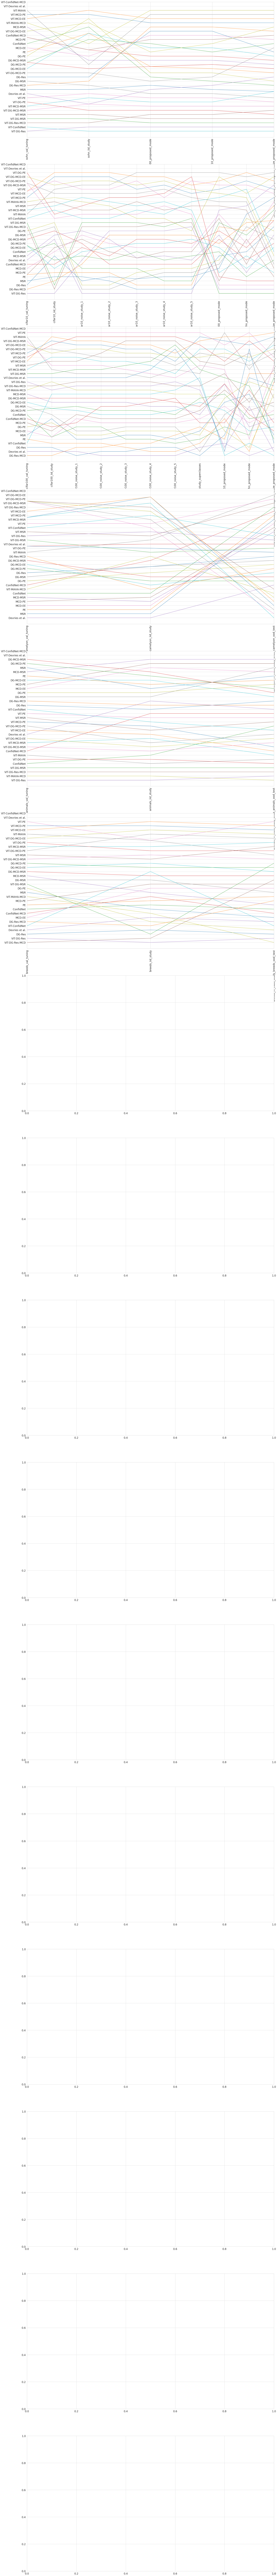

In [212]:
# RANKING PLOTS

scale = 10
sns.set_style("whitegrid")
plt_exps = exp_names
sns.set_context("paper", font_scale=scale * 0.20)
f, axs = plt.subplots(
    nrows=len(plt_exps), ncols=1, figsize=(3 * scale, len(exp_names) * scale * 2)
)
# todo ! supercifar has to be a part of cifar100 exp. check also weird observation regarding val_tuning
for ax_ix, exp in enumerate(plt_exps):
    cols = [c for c in rank_df.columns if c.startswith(exp + "_")]
    cols = (
        ["{}_val_tuning".format(exp), "{}_iid_study".format(exp)]
        + [c for c in cols if "noise" in c]
        + [c for c in cols if "in_class" in c]
        + [c for c in cols if "proposed" in c]
    )
    numeric_exp_df = rank_df[cols]
    # todo DROPNAN?
    confids_list = rank_df.confid.tolist()
    x = range(len(numeric_exp_df.columns))
    for ix in range(len(numeric_exp_df)):
        y = numeric_exp_df.iloc[ix].values
        axs[ax_ix].plot(x, y)
    axs[ax_ix].set_yticks(range(1, len(numeric_exp_df) + 1))
    axs[ax_ix].set_yticklabels(
        rank_df[["confid"] + [c for c in rank_df.columns if c.startswith(exp)]]
        .sort_values(by=numeric_exp_df.columns[0])
        .confid.tolist()
    )
    axs[ax_ix].set_xticks(x)
    axs[ax_ix].set_xticklabels([c for c in numeric_exp_df.columns], rotation=90)
    axs[ax_ix].set_xlim(0, len(numeric_exp_df.columns) - 1)

plt.tight_layout()
plt.show()

In [223]:
colors = [
    "tab:blue",
    "green",
    "tab:purple",
    "orange",
    "red",
    "black",
    "pink",
    "olive",
    "grey",
    "brown",
    "tab:cyan",
    "blue",
    "limegreen",
    "darkmagenta",
    "salmon",
    "tab:blue",
    "green",
    "tab:purple",
    "orange",
]
print(rank_df.confid.str.replace("VIT-", "").unique().tolist())
print(len(colors))

color_dict = {
    conf: colors[ix]
    for ix, conf in enumerate(sorted(rank_df.confid.str.replace("VIT-", "").unique().tolist()))
}
color_dict.update(
    {
        conf: color_dict[conf.replace("VIT-", "")]
        for ix, conf in enumerate(
            rank_df.confid[rank_df.confid.str.contains("VIT")].tolist()
        )
    }
)
print(color_dict)

[
    'MSR',
    'PE',
    'ConfidNet',
    'ConfidNet-MCD',
    'MCD-MSR',
    'MCD-PE',
    'MCD-EE',
    'DG-MSR',
    'DG-PE',
    'DG-MCD-EE',
    'DG-Res',
    'DG-Res-MCD',
    'DG-MCD-PE',
    'DG-MCD-MSR',
    'Devries et al.',
    'MAHA',
    'MAHA-MCD'
]

19

{
    'ConfidNet': 'tab:blue',
    'ConfidNet-MCD': 'green',
    'DG-MCD-EE': 'tab:purple',
    'DG-MCD-MSR': 'orange',
    'DG-MCD-PE': 'red',
    'DG-MSR': 'black',
    'DG-PE': 'pink',
    'DG-Res': 'olive',
    'DG-Res-MCD': 'grey',
    'Devries et al.': 'brown',
    'MAHA': 'tab:cyan',
    'MAHA-MCD': 'blue',
    'MCD-EE': 'limegreen',
    'MCD-MSR': 'darkmagenta',
    'MCD-PE': 'salmon',
    'MSR': 'tab:blue',
    'PE': 'green',
    'VIT-MSR': 'tab:blue',
    'VIT-PE': 'green',
    'VIT-MAHA': 'tab:cyan',
    'VIT-MAHA-MCD': 'blue',
    'VIT-MCD-MSR': 'darkmagenta',
    'VIT-MCD-PE': 'salmon',
    'VIT-MCD-EE': 'limegreen',
    'VIT-DG-MSR': 'black',
    'VIT-DG-PE': 'pink',
    'VIT-DG-Res': 'olive',
    'VIT-DG-Res-MCD': 'grey',
    'VIT-DG-MCD-MSR': 'orange',
    'VIT-DG-MCD-PE': 'red',
    'VIT-DG-MCD-EE': 'tab:purple',
    'VIT-ConfidNet': 'tab:blue',
    'VIT-Devries et al.': 'brown',
    'VIT-ConfidNet-MCD': 'green'
}

In [214]:
# SUM RANKING PLOTS


def plot_sum_ranking(rank_df):
    select_columns = [c for c in rank_df.columns]
    iid_columns = [c for c in select_columns if "iid" in c]
    print("IID", iid_columns)
    in_class_columns = [c for c in select_columns if "in_class" in c]
    print("SUB CLASS", in_class_columns)
    new_class_columns = [
        c for c in select_columns if ("new_class" in c and "proposed" in c)
    ]
    sem_new_class_columns = [
        c for c in new_class_columns if ("cifar10_" in c and "cifar100_" in c)
    ]
    print("SEMANTIC NEW CLASS", sem_new_class_columns)
    nonsem_new_class_columns = [
        c for c in new_class_columns if c not in sem_new_class_columns
    ]
    print("NON-SEMANTIC NEW CLASS", nonsem_new_class_columns)
    noise_columns = [c for c in select_columns if "noise" in c]
    print("NOISE", noise_columns)
    sum_rank_df = rank_df[["confid"]]
    # print(rank_df[rank_df.isna()])
    skipna = False
    sum_rank_df["iid"] = rank_df[iid_columns].sum(
        axis=1, numeric_only=True, skipna=skipna
    )
    sum_rank_df["corruption-shift"] = rank_df[noise_columns].sum(
        axis=1, numeric_only=True, skipna=skipna
    )
    if len(in_class_columns) > 0:
        sum_rank_df["sub-class-shift"] = rank_df[in_class_columns].sum(
            axis=1, numeric_only=True, skipna=skipna
        )
    sum_rank_df["sem.-new-class-shift"] = rank_df[sem_new_class_columns].sum(
        axis=1, numeric_only=True, skipna=skipna
    )
    sum_rank_df["non-sem.-new-class-shift"] = rank_df[nonsem_new_class_columns].sum(
        axis=1, numeric_only=True, skipna=skipna
    )
    sum_rank_df = sum_rank_df.rank(na_option="keep", numeric_only=True, ascending=True)
    sum_rank_df["confid"] = rank_df.confid
    sum_rank_df["aggregated"] = sum_rank_df.sum(
        axis=1, numeric_only=True, skipna=skipna
    ).rank(na_option="keep", ascending=True)

    # sum_rank_df["iid"] = sum_rank_df.apply(lambda row: row["iid"] + 0.5 if row["confid"] == "confidnet_mcd" else row["iid"], axis=1)
    # sum_rank_df["iid"] = sum_rank_df.apply(lambda row: row["iid"] - 0.5 if row["confid"] == "deepgamblers_mcd_mi" else row["iid"], axis=1)

    scale = 10
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=scale * 0.50)
    f, axs = plt.subplots(nrows=1, ncols=1, figsize=(4 * scale, 1.5 * scale * 1.2))
    # todo ! supercifar has to be a part of cifar100 exp. check also weird observation regarding val_tuning

    show_columns = [
        "iid",
        "corruption-shift",
        "sub-class-shift",
        "sem.-new-class-shift",
        "non-sem.-new-class-shift",
        "aggregated",
    ]
    cols = show_columns  # [c for c in sum_rank_df.columns if c.startswith("sum")]
    numeric_exp_df = sum_rank_df[cols]
    # todo DROPNAN?
    confids_list = sum_rank_df.confid.tolist()
    x = range(len(numeric_exp_df.columns))
    ranked_confs = sum_rank_df.sort_values(by=numeric_exp_df.columns[0]).confid.tolist()
    # print(numeric_exp_df)
    # print(confids_list)
    import numpy as np

    seen = [{} for _ in x]
    for ix in range(len(numeric_exp_df)):
        y = numeric_exp_df.iloc[ix].values
        #     axs.plot(x, y, linewidth=3.1, marker=".", ms=18, color=color_dict[sum_rank_df.confid.tolist()[ix]])
        xprev = x[0]
        yprev = y[0]
        textprev = None
        for i, (x_, y_) in enumerate(zip(x, y)):
            if np.isnan(y_):
                continue

            if y_ in seen[x_].keys():
                text = seen[x_][y_]
                text.set_text(text.get_text() + "\n" + confids_list[ix])
            else:
                text = axs.text(
                    x_,
                    y_,
                    confids_list[ix],
                    fontsize=16,
                    horizontalalignment="center",
                    verticalalignment="center",
                )
                seen[x_][y_] = text

            if i == 0:
                arrowprops = None
                xycoords = "data"
                xy = (0, 0)
            else:
                arrowprops = dict(
                    arrowstyle="-",
                    linewidth=3.1,
                    color=color_dict[sum_rank_df.confid.tolist()[ix]],
                    relpos=(0, 0.5),
                    alpha=0.4,
                )
                xycoords = textprev
                xy = (1, 0.5)

            axs.annotate(
                text="",
                xy=xy,
                xytext=(0, 0.5),
                xycoords=xycoords,
                textcoords=text,
                fontsize=16,
                horizontalalignment="center",
                verticalalignment="center",
                arrowprops=arrowprops,
            )
            xprev = x_
            yprev = y_
            textprev = text
    #     break
    axs.set_yticks(range(1, len(numeric_exp_df) + 1))
    axs.set_yticks([])
    # axs.set_yticklabels(ranked_confs)
    axs.set_xticks(x)
    axs.set_xticklabels([c[:5] for c in numeric_exp_df.columns], rotation=90)
    axs.set_xlim(0, len(numeric_exp_df.columns) - 1)
    #     print(axs.get_facecolor())
    axs.annotate(
        "",
        xy=(1.05, 0),
        xytext=(1.05, 1),
        arrowprops=dict(width=3, headwidth=8, headlength=8, color="grey"),
        xycoords="axes fraction",
    )
    axs.annotate(
        "best\nrank",
        xy=(1.054, 1),
        xytext=(1.054, 1),
        xycoords="axes fraction",
        fontsize=16,
        horizontalalignment="left",
        verticalalignment="top",
    )
    axs.annotate(
        "worst\nrank",
        xy=(1.054, 0),
        xytext=(1.054, 0),
        xycoords="axes fraction",
        fontsize=16,
        horizontalalignment="left",
        verticalalignment="bottom",
    )
    plt.tight_layout()
    # plt.savefig("/Users/Paul/research/files/analysis/paper_plots/ranking.png")
    # plt.savefig("/home/tillb/Projects/failure-detection-benchmark/results/ranking.png")
    plt.savefig(base_path / "ranking.png")
    plt.show()


proc = mp.Process(target=plot_sum_ranking, args=[rank_df])
proc.start()
proc.join()
del proc
gc.collect()

/tmp/ipykernel_769885/476315588.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_rank_df["iid"] = rank_df[iid_columns].sum(
/tmp/ipykernel_769885/476315588.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_rank_df["corruption-shift"] = rank_df[noise_columns].sum(
/tmp/ipykernel_769885/476315588.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

260

In [ ]:
# SUM RANKING PLOTS VIT v CNN


def plot_sum_ranking(rank_df):
    logger = mp.log_to_stderr()
    logger.setLevel(logging.INFO)

    select_columns = [c for c in rank_df.columns]
    iid_columns = [c for c in select_columns if "iid" in c]
    print("IID", iid_columns)
    in_class_columns = [c for c in select_columns if "in_class" in c]
    print("SUB CLASS", in_class_columns)
    new_class_columns = [
        c for c in select_columns if ("new_class" in c and "proposed" in c)
    ]
    sem_new_class_columns = [
        c for c in new_class_columns if ("cifar10_" in c and "cifar100_" in c)
    ]
    print("SEMANTIC NEW CLASS", sem_new_class_columns)
    nonsem_new_class_columns = [
        c for c in new_class_columns if c not in sem_new_class_columns
    ]
    print("NON-SEMANTIC NEW CLASS", nonsem_new_class_columns)
    noise_columns = [c for c in select_columns if "noise" in c]
    print("NOISE", noise_columns)
    sum_rank_df = rank_df[["confid"]]
    sum_rank_df.loc[rank_df.confid.str.startswith("VIT"), "confid"] = "VIT"
    sum_rank_df.loc[~rank_df.confid.str.startswith("VIT"), "confid"] = "CNN"
    # logger.info(sum_rank_df)
    # print(rank_df[rank_df.isna()])
    skipna = False
    sum_rank_df["iid"] = rank_df[iid_columns].sum(
        axis=1, numeric_only=True, skipna=skipna
    )
    sum_rank_df["corruption-shift"] = rank_df[noise_columns].sum(
        axis=1, numeric_only=True, skipna=skipna
    )
    if len(in_class_columns) > 0:
        sum_rank_df["sub-class-shift"] = rank_df[in_class_columns].sum(
            axis=1, numeric_only=True, skipna=skipna
        )
    sum_rank_df["sem.-new-class-shift"] = rank_df[sem_new_class_columns].sum(
        axis=1, numeric_only=True, skipna=skipna
    )
    sum_rank_df["non-sem.-new-class-shift"] = rank_df[nonsem_new_class_columns].sum(
        axis=1, numeric_only=True, skipna=skipna
    )
    sum_rank_df = sum_rank_df.groupby("confid").sum()
    sum_rank_df = sum_rank_df.reset_index(drop=False)
    confids = sum_rank_df.confid
    sum_rank_df = sum_rank_df.rank(na_option="keep", numeric_only=True, ascending=True)
    sum_rank_df["confid"] = confids
    sum_rank_df["aggregated"] = sum_rank_df.sum(
        axis=1, numeric_only=True, skipna=skipna
    ).rank(na_option="keep", ascending=True)

    # sum_rank_df["iid"] = sum_rank_df.apply(lambda row: row["iid"] + 0.5 if row["confid"] == "confidnet_mcd" else row["iid"], axis=1)
    # sum_rank_df["iid"] = sum_rank_df.apply(lambda row: row["iid"] - 0.5 if row["confid"] == "deepgamblers_mcd_mi" else row["iid"], axis=1)

    scale = 10
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=scale * 0.50)
    f, axs = plt.subplots(nrows=1, ncols=1, figsize=(4 * scale, 1.5 * scale * 1.2))
    # todo ! supercifar has to be a part of cifar100 exp. check also weird observation regarding val_tuning

    show_columns = [
        "iid",
        "corruption-shift",
        "sub-class-shift",
        "sem.-new-class-shift",
        "non-sem.-new-class-shift",
        "aggregated",
    ]
    cols = show_columns  # [c for c in sum_rank_df.columns if c.startswith("sum")]
    numeric_exp_df = sum_rank_df[cols]
    # todo DROPNAN?
    confids_list = sum_rank_df.confid.tolist()
    x = range(len(numeric_exp_df.columns))
    ranked_confs = sum_rank_df.sort_values(by=numeric_exp_df.columns[0]).confid.tolist()
    # print(numeric_exp_df)
    # print(confids_list)
    import numpy as np

    seen = [{} for _ in x]
    for ix in range(len(numeric_exp_df)):
        y = numeric_exp_df.iloc[ix].values
        #     axs.plot(x, y, linewidth=3.1, marker=".", ms=18, color=color_dict[sum_rank_df.confid.tolist()[ix]])
        xprev = x[0]
        yprev = y[0]
        textprev = None
        for i, (x_, y_) in enumerate(zip(x, y)):
            if np.isnan(y_):
                continue

            if y_ in seen[x_].keys():
                text = seen[x_][y_]
                text.set_text(text.get_text() + "\n" + confids_list[ix])
            else:
                text = axs.text(
                    x_,
                    y_,
                    confids_list[ix],
                    fontsize=16,
                    horizontalalignment="center",
                    verticalalignment="center",
                )
                seen[x_][y_] = text

            if i == 0:
                arrowprops = None
                xycoords = "data"
                xy = (0, 0)
            else:
                arrowprops = dict(
                    arrowstyle="-",
                    linewidth=3.1,
                    color=list(color_dict.values())[ix],
                    relpos=(0, 0.5),
                    alpha=0.4,
                )
                xycoords = textprev
                xy = (1, 0.5)

            axs.annotate(
                text="",
                xy=xy,
                xytext=(0, 0.5),
                xycoords=xycoords,
                textcoords=text,
                fontsize=16,
                horizontalalignment="center",
                verticalalignment="center",
                arrowprops=arrowprops,
            )
            xprev = x_
            yprev = y_
            textprev = text
    #     break
    axs.set_yticks(range(1, len(numeric_exp_df) + 1))
    axs.set_yticks([])
    # axs.set_yticklabels(ranked_confs)
    axs.set_xticks(x)
    axs.set_xticklabels([c[:5] for c in numeric_exp_df.columns], rotation=90)
    axs.set_xlim(0, len(numeric_exp_df.columns) - 1)
    axs.set_ylim(0.5, 2.5)
    #     print(axs.get_facecolor())
    axs.annotate(
        "",
        xy=(1.05, 0),
        xytext=(1.05, 1),
        arrowprops=dict(width=3, headwidth=8, headlength=8, color="grey"),
        xycoords="axes fraction",
    )
    axs.annotate(
        "best\nrank",
        xy=(1.054, 1),
        xytext=(1.054, 1),
        xycoords="axes fraction",
        fontsize=16,
        horizontalalignment="left",
        verticalalignment="top",
    )
    axs.annotate(
        "worst\nrank",
        xy=(1.054, 0),
        xytext=(1.054, 0),
        xycoords="axes fraction",
        fontsize=16,
        horizontalalignment="left",
        verticalalignment="bottom",
    )
    plt.tight_layout()
    # plt.savefig("/Users/Paul/research/files/analysis/paper_plots/ranking.png")
    # plt.savefig("/home/tillb/Projects/failure-detection-benchmark/results/ranking.png")
    plt.savefig(base_path / "vit_v_cnn.png")
    plt.show()


proc = mp.Process(target=plot_sum_ranking, args=[rank_df])
proc.start()
proc.join()
del proc
gc.collect()

In [ ]:
dff.columns

In [ ]:
# BAR PLOTS


scale = 10
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=scale * 0.35)
for exp in ["cifar100"]:
    cols = [c for c in rank_df.columns if c.startswith(exp + "_")]
    cols = (
        ["{}_iid_study".format(exp)]
        + [c for c in cols if "noise" in c]
        + [c for c in cols if "in_class" in c]
        + [c for c in cols if "proposed" in c]
    )
    numeric_exp_df = dff[cols]
    # todo DROPNAN?
    confids_list = dff.confid.tolist()
    x = range(len(numeric_exp_df.columns))
    f, axs = plt.subplots(
        nrows=1, ncols=len(cols), figsize=(scale * len(cols), scale * 2)
    )

    for ix, c in enumerate(cols):
        sns.stripplot(ax=axs[ix], x="confid", y=c, data=dff)
        axs[ix].set_ylim(dff[c].min() - 4, dff[c].max() + 4)
        axs[ix].set_xticklabels(axs[ix].get_xticklabels(), rotation=90)
        title = axs[ix].get_ylabel()
        title = title.replace(exp + "_", "")
        title = title.replace("_proposed_mode", "")
        title = title.replace("_", "-")
        title = title.replace("-study-", "-shift-")
        title = title.replace("in-class", "sub-class")
        title = title.replace("-resize", "")
        axs[ix].set_title(title)
        axs[ix].set_ylabel("")
        axs[ix].set_xlabel("")
    # plt.bar(x="x", height="{}_iid_study".format(exp), data=dff)
    # for ix in range(len(numeric_exp_df)):
    #     y = numeric_exp_df.iloc[ix].values
    #     axs[ax_ix].plot(x, y)
    # axs[ax_ix].set_yticks(range(1, len(numeric_exp_df) + 1))
    # axs[ax_ix].set_yticklabels(rank_df[["confid"] + [c for c in rank_df.columns if c.startswith(exp)]].sort_values(by=numeric_exp_df.columns[0]).confid.tolist())
    # axs[ax_ix].set_xticks(x)
    # axs[ax_ix].set_xticklabels([c for c in numeric_exp_df.columns], rotation = 90)
    # axs[ax_ix].set_xlim(0, len(numeric_exp_df.columns) - 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# OVERVOEW PLOTS

metrics = ["aurc", "accuracy", "failauc"]
plot_exps = ["animals"]  # exp_names
cross_mode = False
scale = 8
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=scale * 0.35)
dims = ["confid"]

# plot_df =

for metric in metrics:
    if not cross_mode:
        for exp in plot_exps:
            plot_data = df[df.study.str.startswith(exp + "_")][
                ["study", "confid", "run", metric]
            ]  # & (data["ne"].str.contains("250")) & (data["ap"]==False)]
            studies = plot_data.study.unique().tolist()
            print(studies, plot_data.columns)
            f, axs = plt.subplots(
                nrows=len(dims),
                ncols=len(studies),
                figsize=(len(studies) * scale * 1.2, len(dims) * scale * 1.2),
            )
            for xix, dim in enumerate(dims):
                for yix, study in enumerate(studies):
                    y = metric
                    sns.stripplot(
                        ax=axs[yix],
                        x=dim,
                        y=metric,
                        data=plot_data[plot_data.study == study],
                        s=scale * 0.8,
                    )
                    sns.boxplot(
                        ax=axs[yix],
                        x=dim,
                        y=metric,
                        data=plot_data[plot_data.study == study],
                        saturation=0,
                        showbox=False,
                        showcaps=False,
                        showfliers=False,
                        whiskerprops=whiskerprops,
                        showmeans=True,
                        meanprops=meanprops,
                        meanline=True,
                    )
                    axs[yix].set_xticklabels(axs[yix].get_xticklabels(), rotation=90)

                    # if "iid" in study and metric == "aurc":
                    #     axs[xix, yix].set_ylim(4, 8)
                    # if "iid" in study and metric == "failauc":
                    #     axs[xix, yix].set_ylim(0.90, 0.96)
            plt.tight_layout()
            plt.savefig(
                "/home/t974t/Projects/failure-detection-benchmark/results/paper_{}_{}.png".format(
                    exp, metric
                )
            )
    else:
        # plot_data = df[df.study.str.startswith(exp)][["study", "confid", "run", "rew", metric]] # & (data["ne"].str.contains("250")) & (data["ap"]==False)]
        plot_data = df[df.study.str.contains("iid_study")][
            ["study", "confid", "run", "rew", metric]
        ]
        print(studies, plot_data.columns)
        f, axs = plt.subplots(
            nrows=len(dims),
            ncols=len(exp_names),
            figsize=(len(exp_names) * scale, len(dims) * scale * 1.2),
        )
        for xix, dim in enumerate(dims):
            for yix, exp in enumerate(exp_names):
                y = metric
                sns.stripplot(
                    ax=axs[yix],
                    x=dim,
                    y=metric,
                    data=plot_data[plot_data.study == "{}_iid_study".format(exp)],
                    s=scale * 0.8,
                )
                sns.boxplot(
                    ax=axs[yix],
                    x=dim,
                    y=metric,
                    data=plot_data[plot_data.study == "{}_iid_study".format(exp)],
                    saturation=0,
                    showbox=False,
                    showcaps=False,
                    showfliers=False,
                    whiskerprops=whiskerprops,
                    showmeans=True,
                    meanprops=meanprops,
                    meanline=True,
                )
                axs[yix].set_xticklabels(axs[yix].get_xticklabels(), rotation=90)
                axs[yix].set_xlabel(exp)
                # if "iid" in study and metric == "aurc":
                #     axs[xix, yix].set_ylim(4, 8)
                # if "iid" in study and metric == "failauc":
                #     axs[xix, yix].set_ylim(0.90, 0.96)
        plt.tight_layout()
        plt.savefig(
            "/home/t974t/Projects/failure-detection-benchmark/results/paper_iid_{}.png".format(
                metric
            )
        )

In [ ]:
# FINAL STRIP PLOTS
import logging


def final_strip_plots():
    logger = mp.log_to_stderr()
    logger.setLevel(logging.INFO)
    metrics = ["accuracy", "aurc", "failauc", "ece", "fail-NLL"]
    plot_exps = [
        "cifar10",
        "cifar100",
        "svhn",
        "breeds",
        "animals",
        "camelyon",
    ]  # exp_names
    cross_mode = False
    scale = 15
    sns.set_style("whitegrid")
    # sns.color_palette("tab20")
    # palette = sns.color_palette()
    # c = []
    # for ix in range(15):
    #     print(ix)
    #     c.append(palette[ix])
    # print(c)
    # random.shuffle(c)
    # print(c)
    sns.set_context("paper", font_scale=scale * 0.35)
    dims = ["confid"]

    studies = [
        "iid-study",
        "sub-class-shift",
        "corruption-shift-1",
        "corruption-shift-2",
        "corruption-shift-3",
        "corruption-shift-4",
        "corruption-shift-5",
        "new-class-shift-cifar10",
        "new-class-shift-cifar10-original-mode",
        "new-class-shift-cifar100",
        "new-class-shift-cifar100-original-mode",
        "new-class-shift-svhn",
        "new-class-shift-svhn-original-mode",
        "new-class-shift-tinyimagenet",
        "new-class-shift-tinyimagenet-original-mode",
    ]

    # print(df)

    for exp in plot_exps:
        logger.info(f"Creating plots for {exp}...")
        pdata = df[df.study.str.startswith(exp + "_")][
            ["study", "confid", "run"] + metrics
        ]

        def fix_studies(n):
            n = n.replace(exp + "_", "")
            n = n.replace("_proposed_mode", "")
            n = n.replace("_", "-")
            n = n.replace("-study-", "-shift-")
            n = n.replace("in-class", "sub-class")
            n = n.replace("noise", "corruption")
            n = n.replace("-resize", "")
            n = n.replace("-wilds-ood-test", "")
            n = n.replace("-ood-test", "")
            n = n.replace("-superclasses", "")
            return n

        plot_studies = pdata.study.unique().tolist()
        plot_studies = [
            c for c in plot_studies if not "val_tuning" in c
        ]  # & (data["ne"].str.contains("250")) & (data["ap"]==False)]
        plot_studies = list(sorted(plot_studies, key=lambda x: fix_studies(x)))
        # print(studies)
        cols = [c for c in plot_studies if exp + "_" in c]
        # plot_studies = studies
        ncols = len(plot_studies)

        nrows = len(metrics)
        f, axs = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(ncols * scale * 1.2, nrows * scale * 1.2),
            squeeze=False,
        )
        # axs = axs.flatten()

        for mix, metric in enumerate(metrics):
            plot_data = df[df.study.str.startswith(exp + "_")][
                ["study", "confid", "run", metric]
            ]
            # print(plot_studies, plot_data.columns)
            saxs = axs[mix]
            for xix, dim in enumerate(dims):
                skipped = 0
                for yix, study in enumerate(studies):
                    if study not in [fix_studies(s) for s in plot_studies]:
                        skipped += 1
                        continue

                    yix = yix - skipped
                    y = metric
                    # print(plot_data.study.apply(fix_studies), study)
                    data = plot_data[
                        plot_data.study.apply(fix_studies) == study
                    ].sort_values(by="confid")
                    plot_colors = [
                        color_dict[conf] for conf in data.confid.unique().tolist()
                    ]
                    # print(plot_colors)
                    palette = sns.color_palette(plot_colors)
                    # print(plot_colors)
                    # print(data.confid.unique().tolist())
                    sns.set_palette(palette)

                    # print(data[~data[dim].str.startswith("VIT")])

                    # order = data[dim].str.replace("VIT-", "").sort_values().unique()
                    # data[dim] = data[dim].str.replace("VIT-", "").sort_values().unique()

                    # if not "noise" in study or "noise_study_3" in study:
                    # print(study)
                    sns.stripplot(
                        ax=saxs[yix],
                        x=dim,
                        y=metric,
                        data=data,
                        s=scale * 1.6,
                        label=dim,
                        alpha=0.5,
                    )
                    sns.boxplot(
                        ax=saxs[yix],
                        x=dim,
                        y=metric,
                        data=data,
                        medianprops=dict(alpha=0),
                        saturation=0,
                        showbox=False,
                        showcaps=False,
                        showfliers=False,
                        whiskerprops=whiskerprops,
                        showmeans=True,
                        meanprops=meanprops,
                        meanline=True,
                    )
                    # axs[yix].set_xticklabels("")
                    saxs[yix].set_xticklabels(saxs[yix].get_xticklabels(), rotation=90)

                    saxs[yix].set_title(fix_studies(study), pad=35)
                    saxs[yix].set_ylabel("")
                    saxs[yix].set_xlabel("")
                    # lim = data[metric].mean() + data[metric].std()
                    #                 saxs[yix].set_ylim(data[metric].min(), data[metric].max())
                    if yix == 0:
                        saxs[yix].set_ylabel(metric)

                    # if yix == 5:
                    #     axs[yix].axis("off")
                    #     axs[yix-1].legend()

                    # if "iid" in study and metric == "aurc":
                    #     axs[xix, yix].set_ylim(4, 8)
                    # if "iid" in study and metric == "failauc":
                    #     axs[xix, yix].set_ylim(0.90, 0.96)
        plt.tight_layout()
        plt.savefig(base_path / f"final_paper_{exp}.png")
        plt.close(f)


proc = mp.Process(target=final_strip_plots)
proc.start()
proc.join()
del proc
gc.collect()

In [ ]:
# FINAL STRIP PLOTS SINGLE COLUMN


def final_strip_plots_sc():
    logger = mp.log_to_stderr()
    logger.setLevel(logging.INFO)
    metrics = ["accuracy", "aurc", "failauc", "ece", "fail-NLL"]
    plot_exps = [
        "cifar10",
        "cifar100",
        "svhn",
        "breeds",
        "animals",
        "camelyon",
    ]  # exp_names
    cross_mode = False
    scale = 15
    sns.set_style("whitegrid")
    # sns.color_palette("tab20")
    # palette = sns.color_palette()
    # c = []
    # for ix in range(15):
    #     print(ix)
    #     c.append(palette[ix])
    # print(c)
    # random.shuffle(c)
    # print(c)
    sns.set_context("paper", font_scale=scale * 0.35)
    dims = ["confid"]

    studies = [
        "iid-study",
        "sub-class-shift",
        "corruption-shift-1",
        "corruption-shift-2",
        "corruption-shift-3",
        "corruption-shift-4",
        "corruption-shift-5",
        "openset_study",
        "new-class-shift-cifar10",
        "new-class-shift-cifar10-original-mode",
        "new-class-shift-cifar100",
        "new-class-shift-cifar100-original-mode",
        "new-class-shift-svhn",
        "new-class-shift-svhn-original-mode",
        "new-class-shift-tinyimagenet",
        "new-class-shift-tinyimagenet-original-mode",
    ]

    # print(df)

    for exp in plot_exps:
        logger.info(f"Creating plots for {exp}...")
        pdata = df[df.study.str.startswith(exp + "_")][
            ["study", "confid", "run"] + metrics
        ]

        def fix_studies(n):
            n = n.replace(exp + "_", "")
            n = n.replace("_proposed_mode", "")
            n = n.replace("_", "-")
            n = n.replace("-study-", "-shift-")
            n = n.replace("in-class", "sub-class")
            n = n.replace("noise", "corruption")
            n = n.replace("-resize", "")
            n = n.replace("-wilds-ood-test", "")
            n = n.replace("-ood-test", "")
            n = n.replace("-superclasses", "")
            return n

        plot_studies = pdata.study.unique().tolist()
        plot_studies = [
            c for c in plot_studies if not "val_tuning" in c
        ]  # & (data["ne"].str.contains("250")) & (data["ap"]==False)]
        plot_studies = list(sorted(plot_studies, key=lambda x: fix_studies(x)))
        # print(studies)
        cols = [c for c in plot_studies if exp + "_" in c]
        # plot_studies = studies
        ncols = len(plot_studies)

        nrows = len(metrics)
        f, axs = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(ncols * scale * 1.2, nrows * scale * 1.2),
            squeeze=False,
        )
        # axs = axs.flatten()

        for mix, metric in enumerate(metrics):
            plot_data = df[df.study.str.startswith(exp + "_")][
                ["study", "confid", "run", metric]
            ]
            # print(plot_studies, plot_data.columns)
            saxs = axs[mix]
            for xix, dim in enumerate(dims):
                skipped = 0
                for yix, study in enumerate(studies):
                    if study not in [fix_studies(s) for s in plot_studies]:
                        skipped += 1
                        continue

                    yix = yix - skipped
                    y = metric
                    # print(plot_data.study.apply(fix_studies), study)
                    data = plot_data[
                        plot_data.study.apply(fix_studies) == study
                    ].sort_values(by="confid")
                    plot_colors = [
                        color_dict[conf] for conf in data.confid.unique().tolist()
                    ]
                    # print(plot_colors)
                    palette = sns.color_palette(plot_colors)
                    # print(plot_colors)
                    # print(data.confid.unique().tolist())
                    sns.set_palette(palette)

                    # print(data[~data[dim].str.startswith("VIT")])

                    order = data[dim].str.replace("VIT-", "").sort_values().unique()

                    # if not "noise" in study or "noise_study_3" in study:
                    # print(study)
                    sns.stripplot(
                        ax=saxs[yix],
                        x=data[~data[dim].str.startswith("VIT")][dim],
                        y=metric,
                        data=data[~data[dim].str.startswith("VIT")],
                        s=scale * 1.6,
                        label=dim,
                        #                         marker="$\u2501$",
                        marker="P",
                        alpha=0.5,
                        order=order,
                        jitter=False,
                    )
                    sns.stripplot(
                        ax=saxs[yix],
                        x=data[data[dim].str.startswith("VIT")][dim].str.replace(
                            "VIT-", ""
                        ),
                        y=metric,
                        data=data[data[dim].str.startswith("VIT")],
                        s=scale * 1.6,
                        label=dim,
                        #                         marker="$\u257B$",
                        marker="X",
                        alpha=0.5,
                        order=order,
                        jitter=False,
                    )
                    sns.boxplot(
                        ax=saxs[yix],
                        x=data[~data[dim].str.startswith("VIT")][dim],
                        y=metric,
                        data=data[~data[dim].str.startswith("VIT")],
                        medianprops=dict(alpha=0),
                        saturation=0,
                        showbox=False,
                        showcaps=False,
                        showfliers=False,
                        whiskerprops=whiskerprops,
                        showmeans=True,
                        meanprops=meanprops,
                        meanline=True,
                        order=order,
                    )
                    sns.boxplot(
                        ax=saxs[yix],
                        x=data[data[dim].str.startswith("VIT-")][dim].str.replace(
                            "VIT-", ""
                        ),
                        y=metric,
                        data=data[data[dim].str.startswith("VIT-")],
                        medianprops=dict(alpha=0),
                        saturation=0,
                        showbox=False,
                        showcaps=False,
                        showfliers=False,
                        whiskerprops=whiskerprops,
                        showmeans=True,
                        meanprops=dict(
                            linewidth=6,
                            alpha=1,
                            zorder=99,
                            dashes=(1, 1, 1, 1, 1, 1, 1),
                        ),
                        meanline=True,
                        order=order,
                    )
                    # axs[yix].set_xticklabels("")
                    saxs[yix].set_xticklabels(saxs[yix].get_xticklabels(), rotation=90)

                    saxs[yix].set_title(fix_studies(study), pad=35)
                    saxs[yix].set_ylabel("")
                    saxs[yix].set_xlabel("")
                    # lim = data[metric].mean() + data[metric].std()
                    #                 saxs[yix].set_ylim(data[metric].min(), data[metric].max())
                    lim0 = data[metric].mean() - data[metric].std()
                    lim1 = data[metric].mean() + data[metric].std()
                    #                     saxs[yix].set_ylim(lim0, lim1)
                    if yix == 0:
                        saxs[yix].set_ylabel(metric)

                    # if yix == 5:
                    #     axs[yix].axis("off")
                    #     axs[yix-1].legend()

                    # if "iid" in study and metric == "aurc":
                    #     axs[xix, yix].set_ylim(4, 8)
                    # if "iid" in study and metric == "failauc":
                    #     axs[xix, yix].set_ylim(0.90, 0.96)
        plt.tight_layout()
        # plt.savefig(
        #     "/home/tillb/Projects/failure-detection-benchmark/results/final_paper_{}_single_column.png".format(
        #         exp
        #     )
        # )
        plt.savefig(base_path / f"final_paper_{exp}_single_column.png")
        plt.close(f)


proc = mp.Process(target=final_strip_plots_sc)
proc.start()
proc.join()
del proc
gc.collect()

In [ ]:
# FINAL STRIP PLOTS BOX


def final_strip_plots_box():
    logger = mp.log_to_stderr()
    logger.setLevel(logging.INFO)
    metrics = ["accuracy", "aurc", "failauc", "ece", "fail-NLL"]
    plot_exps = [
        "cifar10",
        "cifar100",
        "svhn",
        "breeds",
        "animals",
        "camelyon",
    ]  # exp_names
    cross_mode = False
    scale = 15
    sns.set_style("whitegrid")
    # sns.color_palette("tab20")
    # palette = sns.color_palette()
    # c = []
    # for ix in range(15):
    #     print(ix)
    #     c.append(palette[ix])
    # print(c)
    # random.shuffle(c)
    # print(c)
    sns.set_context("paper", font_scale=scale * 0.35)
    dims = ["confid"]

    studies = [
        "iid-study",
        "sub-class-shift",
        "corruption-shift-1",
        "corruption-shift-2",
        "corruption-shift-3",
        "corruption-shift-4",
        "corruption-shift-5",
        "new-class-shift-cifar10",
        "new-class-shift-cifar10-original-mode",
        "new-class-shift-cifar100",
        "new-class-shift-cifar100-original-mode",
        "new-class-shift-svhn",
        "new-class-shift-svhn-original-mode",
        "new-class-shift-tinyimagenet",
        "new-class-shift-tinyimagenet-original-mode",
    ]

    # print(df)

    for exp in plot_exps:
        logger.info(f"Creating plots for {exp}...")
        pdata = df[df.study.str.startswith(exp + "_")][
            ["study", "confid", "run"] + metrics
        ]

        def fix_studies(n):
            n = n.replace(exp + "_", "")
            n = n.replace("_proposed_mode", "")
            n = n.replace("_", "-")
            n = n.replace("-study-", "-shift-")
            n = n.replace("in-class", "sub-class")
            n = n.replace("noise", "corruption")
            n = n.replace("-resize", "")
            n = n.replace("-wilds-ood-test", "")
            n = n.replace("-ood-test", "")
            n = n.replace("-superclasses", "")
            return n

        plot_studies = pdata.study.unique().tolist()
        plot_studies = [
            c for c in plot_studies if not "val_tuning" in c
        ]  # & (data["ne"].str.contains("250")) & (data["ap"]==False)]
        plot_studies = list(sorted(plot_studies, key=lambda x: fix_studies(x)))
        # print(studies)
        cols = [c for c in plot_studies if exp + "_" in c]
        # plot_studies = studies
        ncols = len(plot_studies)

        nrows = len(metrics)
        f, axs = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(ncols * scale * 1.2, nrows * scale * 1.2),
            squeeze=False,
        )
        # axs = axs.flatten()

        for mix, metric in enumerate(metrics):
            plot_data = df[df.study.str.startswith(exp + "_")][
                ["study", "confid", "run", metric]
            ]
            # print(plot_studies, plot_data.columns)
            saxs = axs[mix]
            for xix, dim in enumerate(dims):
                skipped = 0
                for yix, study in enumerate(studies):
                    if study not in [fix_studies(s) for s in plot_studies]:
                        skipped += 1
                        continue

                    yix = yix - skipped
                    y = metric
                    # print(plot_data.study.apply(fix_studies), study)
                    data = plot_data[
                        plot_data.study.apply(fix_studies) == study
                    ].sort_values(by="confid")
                    plot_colors = [
                        color_dict[conf] for conf in data.confid.unique().tolist()
                    ]
                    # print(plot_colors)
                    palette = sns.color_palette(plot_colors)
                    # print(plot_colors)
                    # print(data.confid.unique().tolist())
                    sns.set_palette(palette)

                    # print(data[~data[dim].str.startswith("VIT")])

                    order = data[dim].str.replace("VIT-", "").sort_values().unique()

                    # if not "noise" in study or "noise_study_3" in study:
                    # print(study)
                    # sns.stripplot(
                    #     ax=saxs[yix],
                    #     x=data[~data[dim].str.startswith("VIT")][dim],
                    #     y=metric,
                    #     data=data[~data[dim].str.startswith("VIT")],
                    #     s=scale * 1.6,
                    #     label=dim,
                    #     order=order,
                    # )
                    # sns.stripplot(
                    #     ax=saxs[yix],
                    #     x=data[data[dim].str.startswith("VIT")][dim].str.replace("VIT-", ""),
                    #     y=metric,
                    #     data=data[data[dim].str.startswith("VIT")],
                    #     s=scale * 1.6,
                    #     label=dim,
                    #     marker='X',
                    #     order=order,
                    # )
                    sns.boxplot(
                        ax=saxs[yix],
                        x=data[~data[dim].str.startswith("VIT")][dim],
                        y=metric,
                        data=data[~data[dim].str.startswith("VIT")],
                        medianprops=dict(alpha=0),
                        saturation=1,
                        showbox=True,
                        showcaps=False,
                        showfliers=False,
                        whiskerprops=whiskerprops,
                        showmeans=True,
                        meanprops=meanprops,
                        meanline=True,
                        order=order,
                        boxprops=dict(alpha=0.5),
                    )
                    sns.boxplot(
                        ax=saxs[yix],
                        x=data[data[dim].str.startswith("VIT-")][dim].str.replace(
                            "VIT-", ""
                        ),
                        y=metric,
                        data=data[data[dim].str.startswith("VIT-")],
                        medianprops=dict(alpha=0),
                        saturation=1,
                        showbox=True,
                        showcaps=False,
                        showfliers=False,
                        whiskerprops=whiskerprops,
                        showmeans=True,
                        meanprops=dict(
                            linewidth=6,
                            alpha=1,
                            zorder=99,
                            dashes=(1, 1, 1, 1, 1, 1, 1),
                        ),
                        meanline=True,
                        order=order,
                        boxprops=dict(alpha=0.5),
                    )
                    # axs[yix].set_xticklabels("")
                    saxs[yix].set_xticklabels(saxs[yix].get_xticklabels(), rotation=90)

                    saxs[yix].set_title(fix_studies(study), pad=35)
                    saxs[yix].set_ylabel("")
                    saxs[yix].set_xlabel("")
                    lim0 = data[metric].mean() - data[metric].std()
                    lim1 = data[metric].mean() + data[metric].std()
                    saxs[yix].set_ylim(lim0, lim1)
                    if yix == 0:
                        saxs[yix].set_ylabel(metric)

                    # if yix == 5:
                    #     axs[yix].axis("off")
                    #     axs[yix-1].legend()

                    # if "iid" in study and metric == "aurc":
                    #     axs[xix, yix].set_ylim(4, 8)
                    # if "iid" in study and metric == "failauc":
                    #     axs[xix, yix].set_ylim(0.90, 0.96)
        plt.tight_layout()
        # plt.savefig(
        #     "/home/tillb/Projects/failure-detection-benchmark/results/final_paper_{}_single_column_box.png".format(
        #         exp
        #     )
        # )
        plt.savefig(base_path / f"final_paper_{exp}_single_column_box.png")
        plt.close(f)


proc = mp.Process(target=final_strip_plots_box)
proc.start()
proc.join()
del proc
gc.collect()

In [ ]:
# FINAL STRIP PLOTS Whiskers


def is_outlier(points, threshold=0.1, keep=None):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 

        https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
    """
    assert len(points.shape) == 1
    median = np.median(points, axis=0)
    diff = points - median
    keep_array = np.full((diff.shape[0],), False)
    if keep == "min":
        keep_array = diff < 0
    elif keep == "max":
        keep_array = diff > 0
    # diff = np.sum((diff)**2, axis=-1)
    # diff = np.sqrt(diff)
    diff = np.abs(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return (modified_z_score > threshold) & (~keep_array)


def final_strip_plots_whisk():
    logger = mp.log_to_stderr()
    logger.setLevel(logging.INFO)

    metrics = ["accuracy", "aurc", "failauc", "ece", "fail-NLL"]
    metrics_keep = {
        "accuracy": "max",
        "aurc": "min",
        "failauc": "max",
        "ece": "min",
        "fail-NLL": "min",
    }
    plot_exps = [
        "cifar10",
        "cifar100",
        "svhn",
        "breeds",
        "animals",
        "camelyon",
    ]  # exp_names
    cross_mode = False
    scale = 15
    sns.set_style("whitegrid")
    # sns.color_palette("tab20")
    # palette = sns.color_palette()
    # c = []
    # for ix in range(15):
    #     print(ix)
    #     c.append(palette[ix])
    # print(c)
    # random.shuffle(c)
    # print(c)
    sns.set_context("paper", font_scale=scale * 0.35)
    dims = ["confid"]

    studies = [
        "iid-study",
        "sub-class-shift",
        "corruption-shift-1",
        "corruption-shift-2",
        "corruption-shift-3",
        "corruption-shift-4",
        "corruption-shift-5",
        "openset-study",
        "new-class-shift-cifar10",
        # 'new-class-shift-cifar10-original-mode',
        "new-class-shift-cifar100",
        # 'new-class-shift-cifar100-original-mode',
        "new-class-shift-svhn",
        # 'new-class-shift-svhn-original-mode',
        "new-class-shift-tinyimagenet",
        # 'new-class-shift-tinyimagenet-original-mode'
    ]

    # print(df)

    for exp in plot_exps:
        logger.info(f"Creating plots for {exp}...")
        pdata = df[df.study.str.startswith(exp + "_")][
            ["study", "confid", "run"] + metrics
        ]

        def fix_studies(n):
            n = n.replace(exp + "_", "")
            n = n.replace("_proposed_mode", "")
            n = n.replace("_", "-")
            n = n.replace("-study-", "-shift-")
            n = n.replace("in-class", "sub-class")
            n = n.replace("noise", "corruption")
            n = n.replace("-resize", "")
            n = n.replace("-wilds-ood-test", "")
            n = n.replace("-ood-test", "")
            n = n.replace("-superclasses", "")
            return n

        pdata["study"] = pdata.study.apply(fix_studies)
        pdata = pdata[pdata.study.isin(studies)]
        pdata = pdata.sort_values(by="study", key=lambda x: x.apply(studies.index))

        plot_studies = pdata.study.unique().tolist()
        # plot_studies = [
        #     c for c in plot_studies if not "val_tuning" in c
        # ]
        # plot_studies = list(sorted(plot_studies, key=lambda x: fix_studies(x)))
        # print(studies)
        cols = [c for c in plot_studies if exp + "_" in c]
        # plot_studies = studies
        ncols = len(plot_studies)

        nrows = len(metrics)
        f, axs = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(ncols * scale * 1.2, nrows * scale * 1.2),
            squeeze=False,
        )
        # axs = axs.flatten()

        for mix, metric in enumerate(metrics):
            plot_data = pdata[["study", "confid", "run", metric]]
            # print(plot_studies, plot_data.columns)
            saxs = axs[mix]
            for xix, dim in enumerate(dims):
                # skipped = 0
                for yix, study in enumerate(plot_studies):
                    # if study not in [fix_studies(s) for s in plot_studies]:
                    #     skipped += 1
                    #     continue

                    # yix = yix - skipped
                    y = metric
                    # print(plot_data.study.apply(fix_studies), study)
                    data = plot_data[plot_data.study == study].sort_values(by="confid")
                    # logger.info(data[metric])
                    plot_colors = [
                        color_dict[conf] for conf in data.confid.unique().tolist()
                    ]
                    # print(plot_colors)
                    palette = sns.color_palette(plot_colors)
                    # print(plot_colors)
                    # print(data.confid.unique().tolist())
                    sns.set_palette(palette)

                    # print(data[~data[dim].str.startswith("VIT")])
                    # logger.info(data[data.study == "openset-study"])

                    order = data[dim].str.replace("VIT-", "").sort_values().unique()

                    if len(data[~data[dim].str.startswith("VIT")]) > 0:
                        sns.boxplot(
                            ax=saxs[yix],
                            x=data[~data[dim].str.startswith("VIT")][dim],
                            y=metric,
                            data=data[~data[dim].str.startswith("VIT")],
                            medianprops=dict(alpha=0),
                            saturation=0,
                            showbox=False,
                            showcaps=False,
                            showfliers=False,
                            whiskerprops=whiskerprops,
                            showmeans=True,
                            meanprops=meanprops,
                            meanline=True,
                            order=order,
                        )
                    sns.boxplot(
                        ax=saxs[yix],
                        x=data[data[dim].str.startswith("VIT-")][dim].str.replace(
                            "VIT-", ""
                        ),
                        y=metric,
                        data=data[data[dim].str.startswith("VIT-")],
                        medianprops=dict(alpha=0),
                        saturation=0,
                        showbox=False,
                        showcaps=False,
                        showfliers=False,
                        whiskerprops=whiskerprops,
                        showmeans=True,
                        meanprops=dict(
                            color="k",
                            linewidth=6,
                            alpha=1,
                            zorder=99,
                            dashes=(1, 1, 1, 1, 1, 1, 1),
                        ),
                        meanline=True,
                        order=order,
                    )

                    if len(data[~data[dim].str.startswith("VIT")]) > 0:
                        lcount = len(saxs[yix].lines)
                        ccount = len(saxs[yix].collections)
                        sns.pointplot(
                            ax=saxs[yix],
                            x=data[~data[dim].str.startswith("VIT")][dim],
                            y=metric,
                            data=data[~data[dim].str.startswith("VIT")],
                            join=False,
                            makers="",
                            order=order,
                            ci="sd",
                            capsize=0.6,
                            palette=palette,
                        )
                        trans = transforms.offset_copy(
                            saxs[yix].transData, fig=f, x=-5 / 72, y=0, units="inches"
                        )
                        for l in saxs[yix].lines[lcount:]:
                            l.set_transform(trans)
                        for _ in range(len(saxs[yix].collections[ccount:])):
                            del saxs[yix].collections[-1]

                    lcount = len(saxs[yix].lines)
                    ccount = len(saxs[yix].collections)
                    sns.pointplot(
                        ax=saxs[yix],
                        x=data[data[dim].str.startswith("VIT-")][dim].str.replace(
                            "VIT-", ""
                        ),
                        y=metric,
                        data=data[data[dim].str.startswith("VIT-")],
                        join=False,
                        makers="",
                        order=order,
                        ci="sd",
                        capsize=0.6,
                        palette=palette,
                    )
                    trans = transforms.offset_copy(
                        saxs[yix].transData, fig=f, x=+5 / 72, y=0, units="inches"
                    )
                    for l in saxs[yix].lines[lcount:]:
                        l.set_transform(trans)
                    for _ in range(len(saxs[yix].collections[ccount:])):
                        del saxs[yix].collections[-1]

                    # axs[yix].set_xticklabels("")
                    saxs[yix].set_xticklabels(saxs[yix].get_xticklabels(), rotation=90)

                    saxs[yix].set_title(fix_studies(study), pad=35)
                    saxs[yix].set_ylabel("")
                    saxs[yix].set_xlabel("")
                    data = data.reset_index()
                    # logger.info(f"Before: {len(data)}")
                    data2 = data[
                        is_outlier(data[metric].to_numpy(), keep=metrics_keep[metric])
                    ]
                    data = data[
                        ~is_outlier(data[metric].to_numpy(), keep=metrics_keep[metric])
                    ]
                    # logger.info(f"After:  {len(data)}")
                    # data = data[~is_outlier(data[metric].to_numpy())]
                    lim0 = data[metric].min() - 0.1 * (
                        data[metric].max() - data[metric].min()
                    )
                    lim1 = data[metric].max() + 0.1 * (
                        data[metric].max() - data[metric].min()
                    )
                    saxs[yix].set_ylim(lim0, lim1)
                    for ix, x_ in enumerate(order):
                        if (
                            data2.loc[data2[dim].str.startswith(x_), metric] < lim0
                        ).any():
                            saxs[yix].annotate(
                                text="",
                                xy=((ix + 0.40) / len(order), 0),
                                xytext=((ix + 0.40) / len(order), 0.01),
                                xycoords="axes fraction",
                                arrowprops=dict(
                                    arrowstyle="->,head_length=0.2",
                                    linewidth=4,
                                    alpha=1,
                                    mutation_scale=70,
                                    #                                     mutation_aspect=0.7,
                                    color="k",
                                    relpos=(0, 0),
                                ),
                                annotation_clip=False,
                            )
                        if (
                            data2.loc[data2[dim].str.startswith("VIT-" + x_), metric]
                            < lim0
                        ).any():
                            saxs[yix].annotate(
                                text="",
                                xy=((ix + 0.6) / len(order), 0),
                                xytext=((ix + 0.6) / len(order), 0.01),
                                xycoords="axes fraction",
                                arrowprops=dict(
                                    arrowstyle="->,head_length=0.2",
                                    linewidth=4,
                                    alpha=1,
                                    mutation_scale=70,
                                    #                                     mutation_aspect=2/3,
                                    color="grey",
                                    relpos=(0, 0),
                                ),
                                annotation_clip=False,
                            )
                        if (
                            data2.loc[data2[dim].str.startswith(x_), metric] > lim1
                        ).any():
                            # print("here", ix / len(order))
                            saxs[yix].annotate(
                                text="",
                                xy=((ix + 0.4) / len(order), 1),
                                xytext=((ix + 0.4) / len(order), 0.99),
                                xycoords="axes fraction",
                                arrowprops=dict(
                                    arrowstyle="->,head_length=0.2",
                                    linewidth=4,
                                    alpha=1,
                                    mutation_scale=70,
                                    #                                     mutation_aspect=2/3,
                                    color="k",
                                    relpos=(0, 0),
                                ),
                                annotation_clip=False,
                            )
                        if (
                            data2.loc[data2[dim].str.startswith("VIT-" + x_), metric]
                            > lim1
                        ).any():
                            # print("here", ix / len(order))
                            saxs[yix].annotate(
                                text="",
                                xy=((ix + 0.6) / len(order), 1),
                                xytext=((ix + 0.6) / len(order), 0.99),
                                xycoords="axes fraction",
                                arrowprops=dict(
                                    arrowstyle="->,head_length=0.2",
                                    linewidth=4,
                                    alpha=1,
                                    mutation_scale=70,
                                    #                                     mutation_aspect=2/3,
                                    color="grey",
                                    relpos=(0, 0),
                                ),
                                annotation_clip=False,
                            )
                    if yix == 0:
                        saxs[yix].set_ylabel(metric)

                    # if yix == 5:
                    #     axs[yix].axis("off")
                    #     axs[yix-1].legend()

                    # if "iid" in study and metric == "aurc":
                    #     axs[xix, yix].set_ylim(4, 8)
                    # if "iid" in study and metric == "failauc":
                    #     axs[xix, yix].set_ylim(0.90, 0.96)
        plt.tight_layout()
        # plt.savefig(
        #     "/home/tillb/Projects/failure-detection-benchmark/results/final_paper_{}_single_column_whisk.png".format(
        #         exp
        #     )
        # )
        # plt.savefig(
        #     base_path / f"final_paper_{exp}_single_column_whisk.png"
        # )
        plt.savefig(base_path / f"final_paper_{exp}.png")
        plt.close(f)


proc = mp.Process(target=final_strip_plots_whisk)
proc.start()
proc.join()
del proc
gc.collect()

In [ ]:
# VIT VS CNN BOX


def vit_v_cnn_box(metric):
    logger = mp.log_to_stderr()
    logger.setLevel(logging.INFO)
    plot_exps = [
        "cifar10",
        "cifar100",
        "svhn",
        "breeds",
        "animals",
        "camelyon",
    ]  # exp_names
    cross_mode = False
    scale = 15
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=scale * 0.35)
    dim = "confid"
    
    metric_dict = {
        "aurc": "AURC",
        "failauc": "AUROC",
        "ece": "ECE",
        "accuracy": "accuracy",
    }
    
    dataset_dict = {
        "cifar10": "CIFAR-10",
        "cifar100": "CIFAR-100",
        "animals": "iWildCam",
        "breeds": "BREEDS",
        "camelyon": "CAMELYON",
        "svhn": "SVHN",
    }

    studies = [
        "iid-study",
        # 'sub-class-shift',
        # 'corruption-shift-1',
        # 'corruption-shift-2',
        # 'corruption-shift-3',
        # 'corruption-shift-4',
        # 'corruption-shift-5',
        # 'new-class-shift-cifar10',
        # 'new-class-shift-cifar10-original-mode',
        # 'new-class-shift-cifar100',
        # 'new-class-shift-cifar100-original-mode',
        # 'new-class-shift-svhn',
        # 'new-class-shift-svhn-original-mode',
        # 'new-class-shift-tinyimagenet',
        # 'new-class-shift-tinyimagenet-original-mode'
    ]

    # print(df)

    logger.info("Creating plots...")

    def fix_studies(n):
        n = n.replace("^.*?_", "")
        n = n.replace("_proposed_mode", "")
        n = n.replace("_", "-")
        n = n.replace("-study-", "-shift-")
        n = n.replace("in-class", "sub-class")
        n = n.replace("noise", "corruption")
        n = n.replace("-resize", "")
        n = n.replace("-wilds-ood-test", "")
        n = n.replace("-ood-test", "")
        n = n.replace("-superclasses", "")
        return n

    f, axes = plt.subplots(
        nrows=4, ncols=1, figsize=(4 * scale * 1.2, 4 * scale * 1.2), squeeze=True
    )
    for axs, metric in zip(axes, ["aurc", "ece", "failauc", "accuracy"]):
        plot_data = df[["study", "confid", "run", metric]][
            (df.study.str.contains("iid"))
        ]  # & (~df.confid.str.contains("DG"))]

        y = metric
        data = plot_data.assign(
            dataset=lambda row: row.study.str.split("_", 1, expand=True)[0]
        )
        data["backbone"] = data[dim]
        data.loc[~data[dim].str.startswith("VIT"), "backbone"] = "CNN"
        data.loc[data[dim].str.startswith("VIT"), "backbone"] = "VIT"
        confids = ["ConfidNet", "DG-MCD-EE", "DG-Res", "Devries et al.", "MCD-EE", "MCD-MSR", "MCD-PE", "MSR", "PE", "MAHA"]
    #     print(data.confid)
        data = data[plot_data.confid.str.replace("VIT-", "").isin(confids)]
        data = data[~(data.confid.isin(["VIT-Devries et al.", "VIT-ConfidNet", "VIT-DG-Res", "VIT-DG-Res"]))]
        #     logger.info(data.dataset)
        plot_colors = [color_dict[conf] for conf in data.confid.unique().tolist()]
        # print(plot_colors)
        palette = sns.color_palette(plot_colors)
        # print(plot_colors)
        # print(data.confid.unique().tolist())
        sns.set_palette(palette)

        # print(data[~data[dim].str.startswith("VIT")])

        # order = data[dim].str.replace("VIT-", "").sort_values().unique()


        # if not "noise" in study or "noise_study_3" in study:
        # print(study)
        # sns.stripplot(
        #     ax=saxs[yix],
        #     x=data[~data[dim].str.startswith("VIT")][dim],
        #     y=metric,
        #     data=data[~data[dim].str.startswith("VIT")],
        #     s=scale * 1.6,
        #     label=dim,
        #     order=order,
        # )
        # sns.stripplot(
        #     ax=saxs[yix],
        #     x=data[data[dim].str.startswith("VIT")][dim].str.replace("VIT-", ""),
        #     y=metric,
        #     data=data[data[dim].str.startswith("VIT")],
        #     s=scale * 1.6,
        #     label=dim,
        #     marker='X',
        #     order=order,
        # )
        for i, exp in enumerate(plot_exps):
            axs_ = axs.twinx()
            axs_.yaxis.tick_left()
            axs_.spines["left"].set_position(("data", i - 0.5))
            sns.boxplot(
                ax=axs_,
                x="dataset",
                y=metric,
                hue="backbone",
                data=data[data.dataset == exp],
                # medianprops=dict(alpha=0),
                medianprops=meanprops,
                saturation=1,
                showbox=True,
                showcaps=False,
                showfliers=False,
                whiskerprops=whiskerprops,
                showmeans=True,
                meanprops=dict(alpha=0),
                # meanprops=meanprops,
                # meanline=True,
                order=plot_exps,
                boxprops=dict(alpha=0.5),
            )

            for label in axs_.get_xticklabels() + axs_.get_yticklabels():
                label.set_fontsize(28)
                label.set_bbox(dict(facecolor="white", edgecolor="None", alpha=0.75))

            axs_.grid(False)
            if i != (len(plot_exps) - 1) or metric != 'aurc': 
                axs_.legend().remove()
            else:
                handles, labels = axs_.get_legend_handles_labels()
                axs_.legend(handles, ["CNN", "ViT"], title="classifier")
                
            if i != 0:
                axs_.set_ylabel("")
            else:
                axs_.yaxis.set_label_position("left")
                axs_.set_ylabel(metric_dict[metric])
        # axs[yix].set_xticklabels("")
        axs.set_xticklabels([dataset_dict[exp] for exp in plot_exps])

        # axs.set_title(fix_studies(study), pad=35)
        axs.set_ylabel(metric_dict[metric])
        axs.set_xlabel("")
        axs.yaxis.set_visible(False)
        axs.grid(False)
        
    # lim0 = data[metric].mean() - data[metric].std()
    # lim1 = data[metric].mean() + data[metric].std()
    # saxs[yix].set_ylim(lim0, lim1)
    # if yix == 0:
    #     saxs[yix].set_ylabel(metric)

    # if yix == 5:
    #     axs[yix].axis("off")
    #     axs[yix-1].legend()

    # if "iid" in study and metric == "aurc":
    #     axs[xix, yix].set_ylim(4, 8)
    # if "iid" in study and metric == "failauc":
    #     axs[xix, yix].set_ylim(0.90, 0.96)
    plt.tight_layout()
    # plt.savefig(
    #     "/home/tillb/Projects/failure-detection-benchmark/results/final_paper_{}_single_column_box.png".format(
    #         exp
    #     )
    # )
    plt.savefig(base_path / f"vit_v_cnn.png")
    plt.close(f)


proc = mp.Process(target=vit_v_cnn_box, args=("aurc",))
proc.start()
proc.join()
# proc = mp.Process(target=vit_v_cnn_box, args=("ece",))
# proc.start()
# proc.join()
# proc = mp.Process(target=vit_v_cnn_box, args=("failauc",))
# proc.start()
# proc.join()
# proc = mp.Process(target=vit_v_cnn_box, args=("accuracy",))
# proc.start()
# proc.join()
# proc = mp.Process(target=vit_v_cnn_box, args=("fail-NLL",))
# proc.start()
# proc.join()
del proc
gc.collect()

[INFO/MainProcess] ['MCD-EE', 'MCD-PE', 'PE', 'DG-MCD-EE', 'MAHA', 'MSR', 'MCD-MSR', 'ConfidNet', 'DG-Res']
[INFO/MainProcess] ['MCD-EE', 'MCD-PE', 'PE', 'DG-MCD-EE', 'MAHA', 'MSR', 'MCD-MSR', 'ConfidNet', 'DG-Res']
[INFO/MainProcess] ['MCD-EE', 'MCD-PE', 'PE', 'DG-MCD-EE', 'MAHA', 'MSR', 'MCD-MSR', 'ConfidNet', 'DG-Res']
[INFO/MainProcess] ['MCD-EE', 'MCD-PE', 'PE', 'DG-MCD-EE', 'MAHA', 'MSR', 'MCD-MSR', 'ConfidNet', 'DG-Res']
[INFO/MainProcess] ['MCD-EE', 'MCD-PE', 'PE', 'DG-MCD-EE', 'MAHA', 'MSR', 'MCD-MSR', 'ConfidNet', 'DG-Res']
[INFO/MainProcess] ['MCD-EE', 'MCD-PE', 'PE', 'DG-MCD-EE', 'MAHA', 'MSR', 'MCD-MSR', 'ConfidNet', 'DG-Res']
[INFO/MainProcess] ['MCD-EE', 'MCD-PE', 'PE', 'DG-MCD-EE', 'MAHA', 'MSR', 'MCD-MSR', 'ConfidNet', 'DG-Res']


[0.16127629499999996, 12.697108684349999]

[INFO/MainProcess] ['PE', 'MCD-EE', 'MCD-PE', 'DG-MCD-EE', 'MCD-MSR', 'MSR', 'MAHA', 'Devries et al.', 'DG-Res', 'ConfidNet']
[INFO/MainProcess] ['PE', 'MCD-EE', 'MCD-PE', 'DG-MCD-EE', 'MCD-MSR', 'MSR', 'MAHA', 'Devries et al.', 'DG-Res', 'ConfidNet']
[INFO/MainProcess] ['PE', 'MCD-EE', 'MCD-PE', 'DG-MCD-EE', 'MCD-MSR', 'MSR', 'MAHA', 'Devries et al.', 'DG-Res', 'ConfidNet']
[INFO/MainProcess] ['PE', 'MCD-EE', 'MCD-PE', 'DG-MCD-EE', 'MCD-MSR', 'MSR', 'MAHA', 'Devries et al.', 'DG-Res', 'ConfidNet']
[INFO/MainProcess] ['PE', 'MCD-EE', 'MCD-PE', 'DG-MCD-EE', 'MCD-MSR', 'MSR', 'MAHA', 'Devries et al.', 'DG-Res', 'ConfidNet']
[INFO/MainProcess] ['PE', 'MCD-EE', 'MCD-PE', 'DG-MCD-EE', 'MCD-MSR', 'MSR', 'MAHA', 'Devries et al.', 'DG-Res', 'ConfidNet']
[INFO/MainProcess] ['PE', 'MCD-EE', 'MCD-PE', 'DG-MCD-EE', 'MCD-MSR', 'MSR', 'MAHA', 'Devries et al.', 'DG-Res', 'ConfidNet']


[8.65627224, 63.518698703199995]

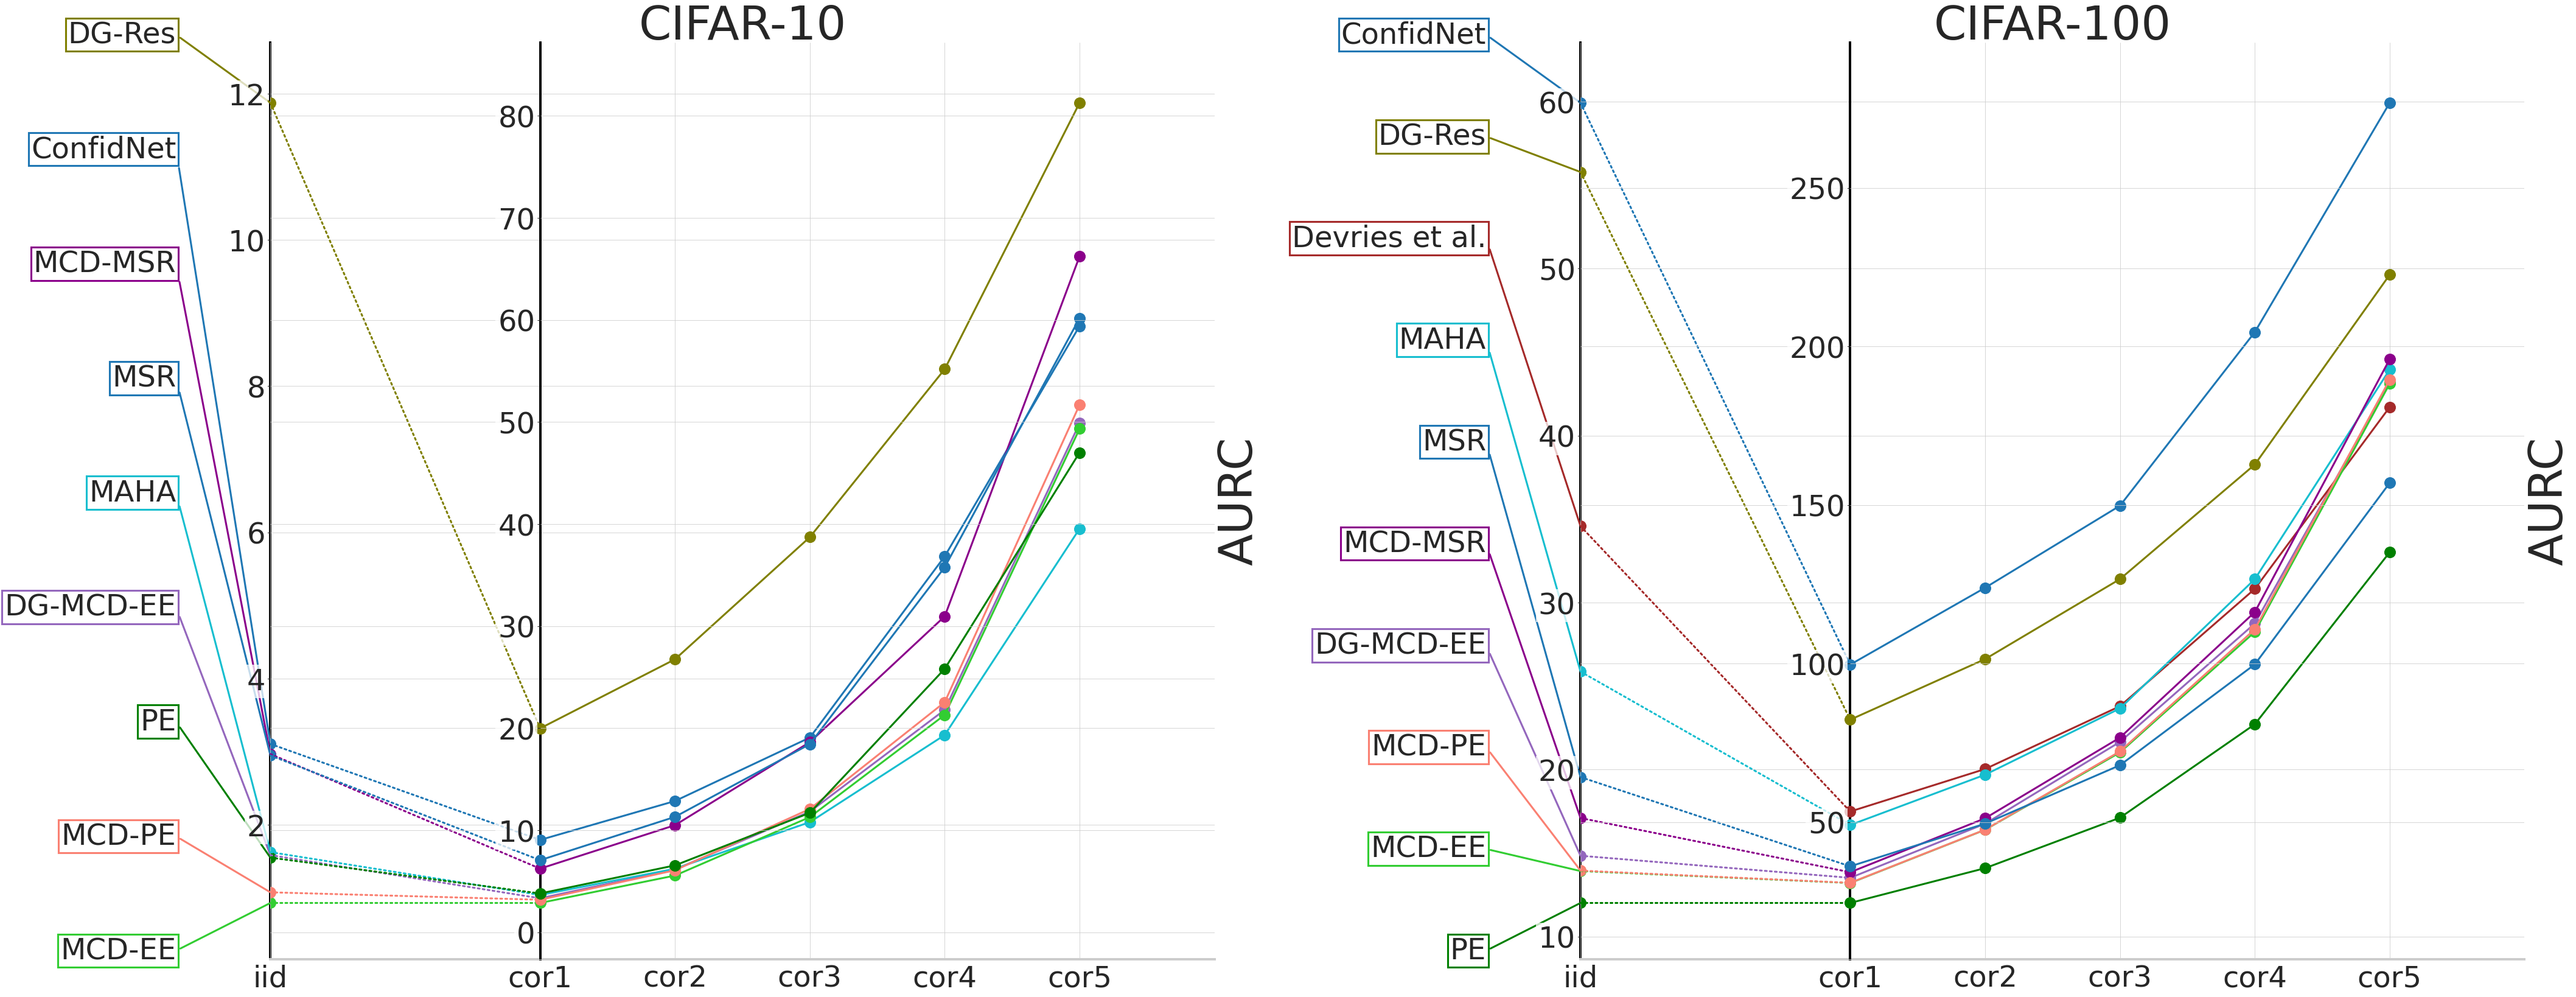

12032

In [225]:
# Rank-style AURC plots


def plot_rank_style(df, exp, metric):
    logger = mp.log_to_stderr()
    logger.setLevel(logging.INFO)

    def fix_studies(n):
        n = n.replace(exp + "_", "")
        n = n.replace("_proposed_mode", "")
        n = n.replace("_", "-")
        n = n.replace("-study-", "-shift-")
        n = n.replace("in-class", "sub-class")
        n = n.replace("noise", "corruption")
        n = n.replace("-resize", "")
        n = n.replace("-wilds-ood-test", "")
        n = n.replace("-ood-test", "")
        n = n.replace("-superclasses", "")
        return n
    
    studies_dict = {
        "iid-study": "iid",
        "sub-class-shift": "sub",  # sub
        "corruption-shift-1": "cor1",  # cor
        "corruption-shift-2": "cor2",
        "corruption-shift-3": "cor3",
        "corruption-shift-4": "cor4",
        "corruption-shift-5": "cor5",
        "new-class-shift-cifar10": "s-ncs\nc10",  # s-ncs (includes openset)
        "new-class-shift-cifar100": "s-ncs\nc100",  # s-ncs (includes openset)
        "new-class-shift-svhn": "ns-ncs\nsvhn",
        "new-class-shift-tinyimagenet": "ns-ncs\nti",
    }
    
    metric_dict = {
        "aurc": "AURC",
        "failauc": "AUROC",
        "ece": "ECE",
        "accuracy": "accuracy",
    }
    
    dataset_dict = {
        "cifar10": "CIFAR-10",
        "cifar100": "CIFAR-100",
        "animals": "iWildCam",
        "breeds": "BREEDS",
        "camelyon": "CAMELYON",
        "svhn": "SVHN",
    }

    studies0 = [
        "iid-study",  # iid
    ]
    studies1 = [
#         "sub-class-shift",  # sub
        "corruption-shift-1",  # cor
        "corruption-shift-2",
        "corruption-shift-3",
        "corruption-shift-4",
        "corruption-shift-5",
    ]
    studies2 = [
#         "new-class-shift-cifar10",  # s-ncs (includes openset)
#         # 'new-class-shift-cifar10-original-mode',
#         "new-class-shift-cifar100",  # ns-ncs
#         # 'new-class-shift-cifar100-original-mode',
#         "new-class-shift-svhn",
#         # 'new-class-shift-svhn-original-mode',
#         "new-class-shift-tinyimagenet",
#         # 'new-class-shift-tinyimagenet-original-mode'
    ]
    scale = 10
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(6 * scale, 2.0 * scale * 1.2))
    fontsize = 48
    
    for axs, exp in zip(axes, ["cifar10", "cifar100"]):
        plot_data = df[df.study.str.startswith(exp + "_")][
            ["study", "confid", "run", metric]
        ]
        plot_data = plot_data[plot_data.confid != "VIT-ConfidNet-MCD"]
        confids = ["ConfidNet", "Devries et al.", "MCD-EE", "MCD-MSR", "MCD-PE", "MSR", "PE", "MAHA", "DG-Res", "DG-MCD-EE"]
        #     print(data.confid)
        plot_data = plot_data[plot_data.confid.str.replace("VIT-", "").isin(confids)]
        # plot_data = plot_data[~(plot_data.confid.isin(["VIT-Devries et al.", "VIT-ConfidNet", "VIT-DG-Res", "VIT-DG-Res"]))]
        plot_data = plot_data[plot_data.confid.str.startswith("VIT")]
        # print(plot_data.confid)
        plot_data.confid = plot_data.confid.str.replace("VIT-", "")
        plot_data["study"] = plot_data.study.apply(fix_studies)
        plot_data = plot_data[plot_data.study.isin(studies0 + studies1 + studies2)]
        plot_data0 = plot_data[plot_data.study.isin(studies0)]
        plot_data0 = plot_data0.groupby(["confid", "study"]).mean().reset_index()
        plot_data0 = plot_data0.sort_values(
            by="study", key=lambda x: x.apply(studies0.index)
        )
        plot_data1 = plot_data[plot_data.study.isin(studies1)]
        plot_data1 = plot_data1.groupby(["confid", "study"]).mean().reset_index()
        plot_data1 = plot_data1.sort_values(
            by="study", key=lambda x: x.apply(studies1.index)
        )
        plot_data2 = plot_data[plot_data.study.isin(studies2)]
        plot_data2 = plot_data2.groupby(["confid", "study"]).mean().reset_index()
        plot_data2 = plot_data2.sort_values(
            by="study", key=lambda x: x.apply(studies2.index)
        )
        scale = 10
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale=scale * 0.50)
        
        x0 = np.arange(len(plot_data0.study.unique()))
        x1 = np.arange(x0[-1] + 1, x0[-1] + 1 + len(plot_data1.study.unique()) / 2, 0.5,)
        x2 = np.arange(x1[-1] + 1, x1[-1] + 1 + len(plot_data2.study.unique()),)
        ranked_confids = (
            plot_data0[plot_data0.study == studies0[0]]
            .sort_values(by=metric, ascending=True)
            .confid.to_list()
        )
        logger.info(ranked_confids)
        twin0 = axs.twinx()
        twin0.yaxis.tick_left()
        twin0.spines["left"].set_position(("data", x1[0]))
#         twin1 = axs.twinx()
#         twin1.yaxis.tick_left()
#         twin1.spines["left"].set_position(("data", x2[0]))
        for c in plot_data0["confid"]:
            confid_data0 = plot_data0[plot_data0["confid"] == c][
                ["study", metric]
            ].reset_index()
            confid_data1 = plot_data1[plot_data1["confid"] == c][
                ["study", metric]
            ].reset_index()
#             confid_data2 = plot_data2[plot_data2["confid"] == c][
#                 ["study", metric]
#             ].reset_index()
            axs.plot(
                x0,
                confid_data0[metric],
                color=color_dict[c],
                marker="o",
                linewidth=3.1,
                ms=18,
            )
            twin0.plot(
                x1,
                confid_data1[metric],
                color=color_dict[c],
                marker="o",
                linewidth=3.1,
                ms=18,
            )
#             twin1.plot(
#                 x2,
#                 confid_data2[metric],
#                 color=color_dict[c],
#                 marker="o",
#                 linewidth=3.1,
#                 ms=18,
#             )
            patch = patches.ConnectionPatch(
                xyA=(x0[-1], confid_data0[metric].iloc[-1]),
                xyB=(x1[0], confid_data1[metric].iloc[0]),
                coordsA="data",
                coordsB="data",
                axesA=axs,
                axesB=twin0,
                arrowstyle="-",
                linestyle=":",
                linewidth=3.1,
                color=color_dict[c],
            )
            twin0.add_artist(patch)
#             patch = patches.ConnectionPatch(
#                 xyA=(x1[-1], confid_data1[metric].iloc[-1]),
#                 xyB=(x2[0], confid_data2[metric].iloc[0]),
#                 coordsA="data",
#                 coordsB="data",
#                 axesA=twin0,
#                 axesB=twin1,
#                 arrowstyle="-",
#                 linestyle=":",
#                 linewidth=3.1,
#                 color=color_dict[c],
#             )
#             twin1.add_artist(patch)
            # logger.info((-0.2, ranked_confids.index(c)/(len(ranked_confids) - 1)))
            axs.annotate(
                xy=(0, confid_data0[metric].iloc[0]),
                xytext=(-0.1, ranked_confids.index(c) / (len(ranked_confids) - 1)),
                textcoords="axes fraction",
                text=c,
                fontsize=fontsize,
                horizontalalignment="right",
                arrowprops=dict(
                    arrowstyle="-",
                    linewidth=3.1,
                    color=color_dict[c],
                    alpha=1,
                    relpos=(1, 0.5),
                ),
                zorder=1,
                # bbox=dict(facecolor=color_dict[c], edgecolor='None', alpha=0.5 ),
                bbox=dict(
                    facecolor="None", edgecolor=color_dict[c], alpha=1, linewidth=3.1
                ),
            )

        studies = (
            list(plot_data0.study.unique())
            + list(plot_data1.study.unique())
            + list(plot_data2.study.unique())
        )
        axs.set_xticks(np.concatenate((x0, x1, x2)))
    #     axs.set_xticklabels(studies, rotation=90)
        axs.set_xticklabels([studies_dict[s] for s in studies], fontsize=fontsize)
        axs.set_xlim(0, x1[-1] + 0.5)

        ylim0 = [plot_data0[metric].min(), plot_data0[metric].max()]

        ylim0[0] -= 0.07 * (ylim0[1] - ylim0[0])
        ylim0[1] += 0.07 * (ylim0[1] - ylim0[0])
        print(ylim0)
        axs.set_ylim(ylim0)
        axs.set_ylabel(metric_dict[metric], fontsize=1.6*fontsize)
        axs.yaxis.set_label_position("right")
        axs.set_axisbelow(False)
        axs.grid(True)
        axs.tick_params(axis="y")
        axs.spines["top"].set_linewidth(0)
        axs.spines["top"].set_zorder(0.5)
        axs.spines["bottom"].set_linewidth(4)
        axs.spines["bottom"].set_zorder(0.5)
        axs.spines["left"].set_linewidth(4)
        axs.spines["left"].set_color("k")
        axs.spines["left"].set_zorder(0.1)
        axs.spines["right"].set_linewidth(0)
        axs.spines["right"].set_color("k")
        axs.spines["right"].set_zorder(0.5)
        axs.set_title(dataset_dict[exp], fontsize=1.6*fontsize)
        for label in axs.get_xticklabels() + axs.get_yticklabels():
            label.set_fontsize(fontsize)
            label.set_bbox(dict(facecolor="white", edgecolor="None", alpha=0.75))

        ylim1 = [plot_data1[metric].min(), plot_data1[metric].max()]
        ylim1[0] -= 0.07 * (ylim1[1] - ylim1[0])
        ylim1[1] += 0.07 * (ylim1[1] - ylim1[0])
        twin0.set_ylim(ylim1)
        twin0.set_axisbelow(False)
        twin0.spines["top"].set_linewidth(0)
        twin0.spines["left"].set_linewidth(4)
        twin0.spines["left"].set_color("k")
        twin0.spines["left"].set_zorder(0.5)
        twin0.spines["right"].set_linewidth(0)
        twin0.spines["right"].set_color("k")
        twin0.spines["right"].set_zorder(0.5)
        twin0.grid(True)
        for label in twin0.get_xticklabels() + twin0.get_yticklabels():
            label.set_fontsize(fontsize)
            label.set_bbox(dict(facecolor="white", edgecolor="None", alpha=0.75))

#         ylim2 = [plot_data2[metric].min(), plot_data2[metric].max()]
#         ylim2[0] -= 0.07 * (ylim2[1] - ylim2[0])
#         ylim2[1] += 0.07 * (ylim2[1] - ylim2[0])
#         twin1.set_ylim(ylim2)
#         twin1.set_axisbelow(False)
#         twin1.spines["left"].set_linewidth(4)
#         twin1.spines["left"].set_color("k")
#         twin1.spines["left"].set_zorder(0.5)
#         twin1.spines["right"].set_linewidth(4)
#         twin1.spines["right"].set_color("k")
#         twin1.spines["right"].set_zorder(0.5)
#         twin1.grid(False)
#         for label in twin1.get_xticklabels() + twin1.get_yticklabels():
#             label.set_fontsize(18)
#             label.set_bbox(dict(facecolor="white", edgecolor="None", alpha=0.75))

    plt.tight_layout()
    plt.savefig(base_path / f"main_plot.png")
    plt.show()
    plt.close(f)


plot_rank_style(df, "cifar10", "aurc")
# proc.start()
# proc.join()
# proc = mp.Process(target=plot_rank_style, args=(df, "cifar10", "ece"))
# proc.start()
# proc.join()
# del proc
gc.collect()

In [ ]:
def _dataset(row):
    tmp = row.study.str.split("_", -1, expand=True)
    tmp.loc[~tmp[1].str.contains("openset"), 1] = ""
    tmp.loc[row.study.str.contains("superclasses"), 0] = "super_cifar100"
    tmp[0] = tmp[0].str.cat(tmp[1])
    return tmp[0]


df = df.assign(
    dataset=_dataset,
    model=lambda row: row.old_name.str.split("model", 1, expand=True)[1].str.split(
        "_", 1, expand=True
    )[0],
)
df.loc[df["model"].isnull(), "model"] = "vit"

confids = ["ConfidNet", "Devries et al.", "MCD-EE", "MCD-MSR", "MCD-PE", "MSR", "PE", "MAHA"]
param_table = (
    df[df.confid.str.contains("VIT") & df.confid.str.replace("VIT-", "").isin(confids) & ~(df.confid.isin(["VIT-Devries et al.", "VIT-ConfidNet", "VIT-DG-Res", "VIT-DG-Res"]))][["dataset", "confid", "study", "lr", "do"]]
)
param_table["wd"] = 0

param_table["batch size"] = 128
param_table.loc[param_table.dataset.str.contains("cifar100"), "batch size"] = 512
param_table.loc[param_table.dataset.str.contains("animals"), "batch size"] = 512

param_table["steps"] = 40000
param_table.loc[param_table.dataset.str.contains("cifar100"), "steps"] = 10000

param_table.confid = param_table.confid.str.replace("VIT-", "").str.replace("-EE", "").str.replace("-PE", "").str.replace("-MSR", "")
param_table = param_table[~param_table.dataset.str.contains("openset")]
param_table = (
    param_table
    .drop_duplicates(["dataset", "confid", "lr", "do"])
    .drop("study", axis=1)
    .sort_values(["dataset", "confid"])
    .reset_index(drop=True)
)

param_table.lr = param_table.lr.astype(float).apply(lambda l: f"{l:1.0e}")
param_table.do = param_table.do.astype(int).apply(lambda l: f"{l:d}")



print(param_table)
datasets = [
    ["cifar10", "cifar100", "super_cifar100", "svhn", "svhnopenset"],
    ["breeds", "animals", "animalsopenset", "camelyon"],
]
param_table.set_index(["dataset", "confid"]).to_latex(
    base_path / f"param_table_0.tex", multirow=True
)
param_table[param_table["dataset"].isin(datasets[1])].set_index("dataset").to_latex(
    base_path / f"param_table_1.tex"
)

In [ ]:
# ************************ RISK PLOTS *******************************
import random

metrics = ["ece"]
plot_exps = ["cifar100"]  # exp_names
cross_mode = False
scale = 15
sns.set_style("whitegrid")
# sns.color_palette("tab20")
# palette = sns.color_palette()
# c = []
# for ix in range(15):
#     print(ix)
#     c.append(palette[ix])
# print(c)
# random.shuffle(c)
# print(c)
# sns.set_palette(c)
sns.set_context("paper", font_scale=scale * 0.5)
dims = ["confid"]


for metric in metrics:
    if not cross_mode:
        for exp in plot_exps:
            plot_data = df[df.study.str.startswith(exp + "_")][
                ["study", "confid", "run", metric]
            ]
            studies = plot_data.study.unique().tolist()
            studies = [
                c for c in studies if not "val_tuning" in c
            ]  # & (data["ne"].str.contains("250")) & (data["ap"]==False)]
            plot_studies = studies  # [c for c in studies if not ("noise" in c or "noise_study_1" in c)]
            cols = [c for c in plot_studies if exp + "_" in c]
            plot_studies = (
                ["{}_iid_study".format(exp)]
                + [c for c in cols if "noise" in c]
                + [c for c in cols if "in_class" in c]
                + [c for c in cols if "proposed" in c]
            )
            # plot_studies = [c for c in cols if "noise" in c]
            print(studies, plot_data.columns)
            ncols = len(plot_studies)
            print("CHECK COLS", ncols, plot_studies)
            f, axs = plt.subplots(
                nrows=len(dims),
                ncols=ncols,
                figsize=(6 * scale * 1.2, len(dims) * scale * 1.2),
            )
            for xix, dim in enumerate(dims):
                for yix, study in enumerate(plot_studies):
                    y = metric
                    data = plot_data[plot_data.study == study].sort_values(by="confid")
                    # if not "noise" in study or "noise_study_3" in study:
                    print(study)
                    sns.stripplot(
                        ax=axs[yix],
                        x=dim,
                        y=metric,
                        data=data,
                        s=scale * 1.6,
                        label=dim,
                    )
                    sns.boxplot(
                        ax=axs[yix],
                        x=dim,
                        y=metric,
                        data=data,
                        medianprops=dict(alpha=0),
                        saturation=0,
                        showbox=False,
                        showcaps=False,
                        showfliers=False,
                        whiskerprops=whiskerprops,
                        showmeans=True,
                        meanprops=meanprops,
                        meanline=True,
                    )
                    # axs[yix].set_xticklabels("")
                    axs[yix].set_xticklabels(axs[yix].get_xticklabels(), rotation=90)
                    title = study
                    title = title.replace(exp + "_", "")
                    title = title.replace("_proposed_mode", "")
                    title = title.replace("_", "-")
                    title = title.replace("-study-", "-shift-")
                    title = title.replace("in-class", "sub-class")
                    title = title.replace("noise", "corruption")
                    title = title.replace("-resize", "")
                    title = title.replace("-wilds-ood-test", "")
                    title = title.replace("-ood-test", "")
                    title = title.replace("-superclasses", "")
                    axs[yix].set_title(title, pad=35)
                    axs[yix].set_ylabel("")
                    axs[yix].set_xlabel("")
                    lim = data[metric].mean() + data[metric].std()
                    axs[yix].set_ylim(axs[yix].get_ylim()[0], lim)
                    if yix == 0:
                        axs[yix].set_ylabel(exp)

                    # if yix == 5:
                    #     axs[yix].axis("off")
                    #     axs[yix-1].legend()

                    # if "iid" in study and metric == "aurc":
                    #     axs[xix, yix].set_ylim(4, 8)
                    # if "iid" in study and metric == "failauc":
                    #     axs[xix, yix].set_ylim(0.90, 0.96)
            plt.tight_layout()
            plt.savefig(base_path / "RISK_final_paper_{}_{}.png".format(exp, metric))